In [1]:
# Cell 1: Install required packages
!pip install -q pandas numpy scikit-learn xgboost lightgbm matplotlib seaborn gradio shap

print("✓ All packages installed")

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/texttable-1.7.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.13a0+0d33366-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will 

In [2]:
# Cell 1: Environment Setup
"""
Antibiotic Resistance Prediction System
========================================
Predicts antibiotic susceptibility to guide empiric therapy selection.

Data: ARMD-MGB Dataset
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
import pickle
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, 
    precision_recall_curve, confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve
import xgboost as xgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

plt.style.use('seaborn-v0_8-whitegrid')
COLORS = plt.cm.tab20.colors

print("✓ Libraries loaded")
print(f"  Pandas: {pd.__version__}")
print(f"  XGBoost: {xgb.__version__}")

✓ Libraries loaded
  Pandas: 2.2.2
  XGBoost: 2.1.1


In [3]:
# Cell 2: Configuration

class Config:
    """Central configuration for the pipeline."""
    
    DATA_PATH = Path("/workspace/armd-mgb/downloads")
    OUTPUT_PATH = Path("/workspace/armd-mgb/outputs")
    
    TARGET_ANTIBIOTICS = [
        'ciprofloxacin',
        'levofloxacin', 
        'trimethoprim_sulfamethoxazole',
        'nitrofurantoin',
        'ceftriaxone',
        'cefazolin',
        'ampicillin',
        'ampicillin_sulbactam',
        'piperacillin_tazobactam',
        'gentamicin',
        'cefepime',
        'meropenem',
        'aztreonam',
        'tobramycin',
        'amikacin'
    ]
    
    MIN_TRAIN_SAMPLES = 500
    MIN_TEST_SAMPLES = 100
    MIN_POSITIVE_RATE = 0.005
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    TOP_N_ORGANISMS = 30
    
    OUTPUT_PATH.mkdir(exist_ok=True, parents=True)

config = Config()
print(f"✓ Configuration loaded")
print(f"  Data path: {config.DATA_PATH}")
print(f"  Output path: {config.OUTPUT_PATH}")
print(f"  Target antibiotics: {len(config.TARGET_ANTIBIOTICS)}")

✓ Configuration loaded
  Data path: /workspace/armd-mgb/downloads
  Output path: /workspace/armd-mgb/outputs
  Target antibiotics: 15


In [4]:
# Cell 3: Load All Data Files

def load_all_data(data_path):
    """Load all CSV files from data directory."""
    dataframes = {}
    
    print("Loading data files...")
    print("="*60)
    
    for filepath in data_path.glob("*.csv"):
        name = filepath.stem
        try:
            df = pd.read_csv(filepath, low_memory=False)
            dataframes[name] = df
            print(f"✓ {name}: {df.shape[0]:,} rows × {df.shape[1]} cols")
        except Exception as e:
            print(f"✗ {name}: {e}")
    
    for filepath in data_path.glob("*.csv.gz"):
        name = filepath.stem.replace('.csv', '')
        try:
            df = pd.read_csv(filepath, compression='gzip', low_memory=False)
            dataframes[name] = df
            print(f"✓ {name} (gzip): {df.shape[0]:,} rows × {df.shape[1]} cols")
        except Exception as e:
            print(f"✗ {name}: {e}")
    
    print(f"\n✓ Loaded {len(dataframes)} tables")
    return dataframes

dataframes = load_all_data(config.DATA_PATH)

Loading data files...
✓ ADI_deid_tj: 1,119,308 rows × 6 cols
✓ comorbidity_deid_tj: 5,932,683 rows × 6 cols
✓ demographics_deid_tj: 1,119,255 rows × 5 cols
✓ microbiology_cohort_deid_tj_updated: 4,960,599 rows × 20 cols
✓ nursing_home_visits_deid_tj: 446,141 rows × 6 cols
✓ prior_abx_deid_tj: 10,273,265 rows × 9 cols
✓ prior_micro_deid_tj: 40,754,207 rows × 11 cols
✓ prior_org_deid_tj: 2,298,843 rows × 8 cols
✓ prior_procedures_deid_tj: 453,463 rows × 6 cols
✓ ward_type_deid_tj: 1,119,256 rows × 9 cols

✓ Loaded 10 tables


In [5]:
# Cell 4: Identify Main Tables

print("="*60)
print("TABLE IDENTIFICATION")
print("="*60)

MICRO_TABLE_KEYWORDS = ['microbiology', 'micro', 'ast', 'suscept', 'culture']

df_micro = None
micro_table_name = None

for name, df in dataframes.items():
    name_lower = name.lower()
    if any(kw in name_lower for kw in MICRO_TABLE_KEYWORDS):
        if df.shape[0] > 100000:
            df_micro = df
            micro_table_name = name
            print(f"✓ Microbiology table: {name}")
            print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} cols")
            break

DEMO_TABLE_KEYWORDS = ['demo', 'patient', 'cohort']

df_demo = None
demo_table_name = None

for name, df in dataframes.items():
    name_lower = name.lower()
    cols_lower = [c.lower() for c in df.columns]
    
    has_age = any('age' in c for c in cols_lower)
    has_gender = any(g in c for c in cols_lower for g in ['gender', 'sex'])
    
    if has_age and has_gender:
        df_demo = df
        demo_table_name = name
        print(f"✓ Demographics table: {name}")
        print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} cols")
        break

if df_micro is None:
    print("⚠️ Could not auto-identify microbiology table")
    print("Available tables:", list(dataframes.keys()))

TABLE IDENTIFICATION
✓ Microbiology table: microbiology_cohort_deid_tj_updated
  Shape: 4,960,599 rows × 20 cols
✓ Demographics table: demographics_deid_tj
  Shape: 1,119,255 rows × 5 cols


In [6]:
# Cell 5: Explore Microbiology Data Structure

print("="*60)
print("MICROBIOLOGY DATA EXPLORATION")
print("="*60)

print("\n1. COLUMNS:")
for i, col in enumerate(df_micro.columns):
    null_pct = df_micro[col].isnull().mean() * 100
    print(f"   {i+1}. {col} ({df_micro[col].dtype}) - {null_pct:.1f}% null")

print("\n2. CULTURE TYPES:")
if 'culture_description' in df_micro.columns:
    print(df_micro['culture_description'].value_counts())
elif 'spec_type_desc' in df_micro.columns:
    print(df_micro['spec_type_desc'].value_counts().head(10))

print("\n3. TOP 15 ORGANISMS:")
org_col = None
for col in ['organism', 'org_name', 'organism_name']:
    if col in df_micro.columns:
        org_col = col
        break
if org_col:
    print(df_micro[org_col].value_counts().head(15))

print("\n4. TOP 15 ANTIBIOTICS:")
abx_col = None
for col in ['antibiotic', 'ab_name', 'antibiotic_name']:
    if col in df_micro.columns:
        abx_col = col
        break
if abx_col:
    print(df_micro[abx_col].value_counts().head(15))

print("\n5. SUSCEPTIBILITY RESULTS (TARGET):")
for col in ['AST_pheno', 'CLSI_2022_pheno', 'interpretation', 'susceptibility']:
    if col in df_micro.columns:
        print(f"\n{col}:")
        print(df_micro[col].value_counts())

MICROBIOLOGY DATA EXPLORATION

1. COLUMNS:
   1. anon_id (int64) - 0.0% null
   2. pat_enc_csn_id_coded (int64) - 0.0% null
   3. order_proc_id_coded (int64) - 0.0% null
   4. culture_description (object) - 0.0% null
   5. organism (object) - 18.3% null
   6. neg_cx (object) - 82.1% null
   7. mult_org_ast (object) - 84.1% null
   8. has_AST (object) - 17.9% null
   9. prelim_AST (object) - 97.1% null
   10. AST_panel (object) - 17.9% null
   11. enzyme_class (object) - 99.4% null
   12. enzyme (object) - 99.6% null
   13. AST_code (object) - 17.9% null
   14. antibiotic (object) - 19.1% null
   15. AST_inequality (object) - 46.6% null
   16. AST_val1 (float64) - 29.9% null
   17. AST_val2 (float64) - 97.6% null
   18. AST_pheno (object) - 25.1% null
   19. CLSI_2022_pheno (object) - 38.8% null
   20. order_time_jittered_utc_shifted (object) - 0.0% null

2. CULTURE TYPES:
culture_description
URINE                2941253
BLOOD                1432368
RESPIRATORY_TRACT     586978
Name: co

In [7]:
# Cell 6: Data Cleaning and Standardization

print("="*60)
print("DATA CLEANING")
print("="*60)

df = df_micro.copy()

COLUMN_MAP = {
    'organism': 'organism',
    'antibiotic': 'antibiotic', 
    'AST_pheno': 'susceptibility',
    'culture_description': 'specimen_type',
    'order_proc_id_coded': 'culture_id',
    'order_time_jittered_utc_shifted': 'culture_datetime'
}

for old_name, new_name in COLUMN_MAP.items():
    if old_name in df.columns and old_name != new_name:
        df = df.rename(columns={old_name: new_name})

print(f"Initial rows: {len(df):,}")

valid_suscept = ['Susceptible', 'Resistant', 'Intermediate']
if 'susceptibility' in df.columns:
    df = df[df['susceptibility'].isin(valid_suscept)]
    print(f"After filtering to S/R/I: {len(df):,}")

df['is_resistant'] = (df['susceptibility'] == 'Resistant').astype(int)

print(f"\nResistance distribution:")
print(df['is_resistant'].value_counts())
print(f"Overall resistance rate: {df['is_resistant'].mean():.1%}")

if 'culture_datetime' in df.columns:
    df['culture_datetime'] = pd.to_datetime(df['culture_datetime'], errors='coerce')
    df['culture_date'] = df['culture_datetime'].dt.date
    print(f"\nDate range: {df['culture_datetime'].min()} to {df['culture_datetime'].max()}")

df = df[df['antibiotic'].isin(config.TARGET_ANTIBIOTICS)]
print(f"After filtering to target antibiotics: {len(df):,}")

critical_cols = ['culture_id', 'organism', 'antibiotic', 'is_resistant']
df = df.dropna(subset=[c for c in critical_cols if c in df.columns])
print(f"After removing missing critical data: {len(df):,}")

print(f"\n✓ Cleaning complete")
print(f"Final shape: {df.shape}")

DATA CLEANING
Initial rows: 4,960,599
After filtering to S/R/I: 3,639,329

Resistance distribution:
is_resistant
0    2997635
1     641694
Name: count, dtype: int64
Overall resistance rate: 17.6%

Date range: 1931-06-16 00:00:00 to 2108-10-29 00:00:00
After filtering to target antibiotics: 2,444,857
After removing missing critical data: 2,434,248

✓ Cleaning complete
Final shape: (2434248, 22)


In [8]:
# Cell 7: Identify Patient ID Column

print("="*60)
print("PATIENT IDENTIFICATION")
print("="*60)

patient_id_col = None
for col in df.columns:
    col_lower = col.lower()
    if any(x in col_lower for x in ['anon_id', 'patient_id', 'subject_id', 'pat_id']):
        patient_id_col = col
        break

if patient_id_col:
    print(f"✓ Patient ID column: {patient_id_col}")
    print(f"  Unique patients: {df[patient_id_col].nunique():,}")
else:
    print("⚠️ No patient ID found - checking all columns:")
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'int64':
            print(f"  {col}: {df[col].nunique():,} unique values")

PATIENT_ID_COL = patient_id_col or 'anon_id'
print(f"\nUsing: {PATIENT_ID_COL}")

PATIENT IDENTIFICATION
✓ Patient ID column: anon_id
  Unique patients: 95,720

Using: anon_id


In [9]:
# Cell 8: Create Culture-Level Dataset (Pivot Antibiotics to Columns)

print("="*60)
print("CREATING CULTURE-LEVEL DATASET")
print("="*60)

culture_meta_cols = ['culture_id', 'specimen_type', 'organism', 'culture_datetime', 'culture_date']
if PATIENT_ID_COL in df.columns:
    culture_meta_cols.append(PATIENT_ID_COL)

for col in df.columns:
    if any(x in col.lower() for x in ['age', 'gender', 'sex', 'race']):
        if col not in culture_meta_cols:
            culture_meta_cols.append(col)

culture_meta_cols = [c for c in culture_meta_cols if c in df.columns]

print(f"Culture metadata columns: {culture_meta_cols}")

df_cultures = df[culture_meta_cols].drop_duplicates(subset=['culture_id'])
print(f"Unique cultures: {len(df_cultures):,}")

df_pivot = df.pivot_table(
    index='culture_id',
    columns='antibiotic', 
    values='is_resistant',
    aggfunc='max'
)

df_pivot.columns = [f'resist_{col}' for col in df_pivot.columns]
df_pivot = df_pivot.reset_index()

print(f"Pivoted antibiotic columns: {len(df_pivot.columns) - 1}")

df_cultures = df_cultures.merge(df_pivot, on='culture_id', how='inner')
print(f"Final culture dataset: {len(df_cultures):,} rows")

print(f"\nSample:")
display(df_cultures.head(3))

CREATING CULTURE-LEVEL DATASET
Culture metadata columns: ['culture_id', 'specimen_type', 'organism', 'culture_datetime', 'culture_date', 'anon_id']
Unique cultures: 204,061
Pivoted antibiotic columns: 15
Final culture dataset: 204,061 rows

Sample:


,culture_id,specimen_type,organism,culture_datetime,culture_date,anon_id,resist_amikacin,resist_ampicillin,resist_ampicillin_sulbactam,resist_aztreonam,resist_cefazolin,resist_cefepime,resist_ceftriaxone,resist_ciprofloxacin,resist_gentamicin,resist_levofloxacin,resist_meropenem,resist_nitrofurantoin,resist_piperacillin_tazobactam,resist_tobramycin,resist_trimethoprim_sulfamethoxazole
0,767654,URINE,ESCHERICHIA COLI,1939-04-16,1939-04-16,111803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,767617,RESPIRATORY_TRACT,STAPHYLOCOCCUS AUREUS,1958-10-12,1958-10-12,2317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,916779,URINE,ESCHERICHIA COLI,1974-04-24,1974-04-24,162484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0


In [10]:
# Cell 9: Engineer Organism Features

print("="*60)
print("ORGANISM FEATURE ENGINEERING")
print("="*60)

organism_counts = df_cultures['organism'].value_counts()
top_organisms = organism_counts.head(config.TOP_N_ORGANISMS).index.tolist()

print(f"Top {config.TOP_N_ORGANISMS} organisms (covering {organism_counts.head(config.TOP_N_ORGANISMS).sum()/len(df_cultures)*100:.1f}% of cultures):")
for i, org in enumerate(top_organisms[:10], 1):
    count = organism_counts[org]
    print(f"  {i}. {org}: {count:,} ({count/len(df_cultures)*100:.1f}%)")

organism_features = []
for org in top_organisms:
    col_name = f"org_{org.lower().replace(' ', '_').replace('(', '').replace(')', '')}"
    df_cultures[col_name] = (df_cultures['organism'] == org).astype(int)
    organism_features.append(col_name)

df_cultures['org_other'] = (~df_cultures['organism'].isin(top_organisms)).astype(int)
organism_features.append('org_other')

print(f"\n✓ Created {len(organism_features)} organism features")

GRAM_POSITIVE = ['STAPHYLOCOCCUS', 'STREPTOCOCCUS', 'ENTEROCOCCUS']
GRAM_NEGATIVE = ['ESCHERICHIA', 'KLEBSIELLA', 'PSEUDOMONAS', 'PROTEUS', 
                 'ENTEROBACTER', 'SERRATIA', 'CITROBACTER', 'ACINETOBACTER']

def classify_gram(org):
    org_upper = str(org).upper()
    if any(gp in org_upper for gp in GRAM_POSITIVE):
        return 'gram_positive'
    elif any(gn in org_upper for gn in GRAM_NEGATIVE):
        return 'gram_negative'
    else:
        return 'other'

df_cultures['gram_category'] = df_cultures['organism'].apply(classify_gram)
print(f"\nGram stain distribution:")
print(df_cultures['gram_category'].value_counts())

for cat in ['gram_positive', 'gram_negative', 'other']:
    df_cultures[f'gram_{cat}'] = (df_cultures['gram_category'] == cat).astype(int)

organism_features.extend(['gram_gram_positive', 'gram_gram_negative', 'gram_other'])

ORGANISM FEATURE ENGINEERING
Top 30 organisms (covering 97.2% of cultures):
  1. ESCHERICHIA COLI: 88,915 (43.6%)
  2. KLEBSIELLA PNEUMONIAE: 19,834 (9.7%)
  3. STAPHYLOCOCCUS AUREUS: 17,872 (8.8%)
  4. PSEUDOMONAS AERUGINOSA: 11,325 (5.5%)
  5. ENTEROCOCCUS FAECALIS: 11,052 (5.4%)
  6. PROTEUS MIRABILIS: 6,760 (3.3%)
  7. STAPHYLOCOCCUS EPIDERMIDIS: 5,251 (2.6%)
  8. ENTEROBACTER CLOACAE COMPLEX: 3,832 (1.9%)
  9. COAGULASE NEGATIVE STAPHYLOCOCCUS (OTHER): 3,642 (1.8%)
  10. ENTEROCOCCUS FAECIUM: 2,996 (1.5%)

✓ Created 31 organism features

Gram stain distribution:
gram_category
gram_negative    144828
gram_positive     53427
other              5806
Name: count, dtype: int64


In [11]:
# Cell 10: Engineer Specimen Features

print("="*60)
print("SPECIMEN FEATURE ENGINEERING") 
print("="*60)

print("Specimen types:")
print(df_cultures['specimen_type'].value_counts())

specimen_features = []
for spec in df_cultures['specimen_type'].unique():
    if pd.notna(spec):
        col_name = f"spec_{spec.lower().replace(' ', '_').replace('/', '_')}"
        df_cultures[col_name] = (df_cultures['specimen_type'] == spec).astype(int)
        specimen_features.append(col_name)

print(f"\n✓ Created {len(specimen_features)} specimen features")

SPECIMEN FEATURE ENGINEERING
Specimen types:
specimen_type
URINE                147710
BLOOD                 31726
RESPIRATORY_TRACT     24625
Name: count, dtype: int64

✓ Created 3 specimen features


In [12]:
# Cell 11: Engineer Temporal Features

print("="*60)
print("TEMPORAL FEATURE ENGINEERING")
print("="*60)

temporal_features = []

if 'culture_datetime' in df_cultures.columns:
    df_cultures['culture_datetime'] = pd.to_datetime(df_cultures['culture_datetime'])
    
    df_cultures['hour_of_day'] = df_cultures['culture_datetime'].dt.hour
    df_cultures['day_of_week'] = df_cultures['culture_datetime'].dt.dayofweek
    df_cultures['month'] = df_cultures['culture_datetime'].dt.month
    df_cultures['year'] = df_cultures['culture_datetime'].dt.year
    df_cultures['quarter'] = df_cultures['culture_datetime'].dt.quarter
    
    df_cultures['is_weekend'] = (df_cultures['day_of_week'] >= 5).astype(int)
    df_cultures['is_night'] = ((df_cultures['hour_of_day'] >= 19) | 
                               (df_cultures['hour_of_day'] < 7)).astype(int)
    
    temporal_features = ['hour_of_day', 'day_of_week', 'month', 'year', 
                        'quarter', 'is_weekend', 'is_night']
    
    print(f"✓ Created {len(temporal_features)} temporal features")
    print(f"\nYear distribution:")
    print(df_cultures['year'].value_counts().sort_index())
else:
    print("⚠️ No datetime column found")

TEMPORAL FEATURE ENGINEERING
✓ Created 7 temporal features

Year distribution:
year
1931      9
1932     82
1933    200
1934    289
1935    375
       ... 
2104    674
2105    444
2106    334
2107    177
2108     30
Name: count, Length: 178, dtype: int64


In [13]:
# Cell 12: Engineer Demographic Features

print("="*60)
print("DEMOGRAPHIC FEATURE ENGINEERING")
print("="*60)

demographic_features = []

age_cols = [c for c in df_cultures.columns if 'age' in c.lower()]
if age_cols:
    age_col = age_cols[0]
    print(f"Age column: {age_col}")
    print(f"  Range: {df_cultures[age_col].min()} - {df_cultures[age_col].max()}")
    
    df_cultures[age_col] = df_cultures[age_col].fillna(df_cultures[age_col].median())
    
    df_cultures['age_normalized'] = (df_cultures[age_col] - df_cultures[age_col].min()) / \
                                    (df_cultures[age_col].max() - df_cultures[age_col].min())
    
    df_cultures['age_group'] = pd.cut(
        df_cultures[age_col],
        bins=[0, 18, 40, 65, 80, 150],
        labels=['pediatric', 'young_adult', 'middle_age', 'senior', 'elderly']
    )
    
    for group in ['pediatric', 'young_adult', 'middle_age', 'senior', 'elderly']:
        df_cultures[f'age_{group}'] = (df_cultures['age_group'] == group).astype(int)
        demographic_features.append(f'age_{group}')
    
    demographic_features.append('age_normalized')
    print(f"\nAge group distribution:")
    print(df_cultures['age_group'].value_counts())

gender_cols = [c for c in df_cultures.columns if any(x in c.lower() for x in ['gender', 'sex'])]
if gender_cols:
    gender_col = gender_cols[0]
    print(f"\nGender column: {gender_col}")
    print(df_cultures[gender_col].value_counts())
    
    df_cultures['is_female'] = df_cultures[gender_col].str.lower().str.contains('f').fillna(0).astype(int)
    df_cultures['is_male'] = df_cultures[gender_col].str.lower().str.contains('m').fillna(0).astype(int)
    demographic_features.extend(['is_female', 'is_male'])

print(f"\n✓ Created {len(demographic_features)} demographic features")

DEMOGRAPHIC FEATURE ENGINEERING

✓ Created 0 demographic features


In [14]:
# Cell 13: Compile All Feature Groups

print("="*60)
print("FEATURE COMPILATION")
print("="*60)

FEATURE_GROUPS = {
    'organism': organism_features,
    'specimen': specimen_features,
    'temporal': temporal_features,
    'demographic': demographic_features
}

ALL_FEATURES = []
for group_name, features in FEATURE_GROUPS.items():
    ALL_FEATURES.extend(features)
    print(f"{group_name}: {len(features)} features")

print(f"\nTotal features: {len(ALL_FEATURES)}")

missing_features = [f for f in ALL_FEATURES if f not in df_cultures.columns]
if missing_features:
    print(f"\n⚠️ Missing features: {missing_features}")
    ALL_FEATURES = [f for f in ALL_FEATURES if f in df_cultures.columns]

TARGET_COLS = [f'resist_{abx}' for abx in config.TARGET_ANTIBIOTICS 
               if f'resist_{abx}' in df_cultures.columns]

print(f"Target antibiotics: {len(TARGET_COLS)}")
print(f"\n✓ Features compiled")

FEATURE COMPILATION
organism: 34 features
specimen: 3 features
temporal: 7 features
demographic: 0 features

Total features: 44
Target antibiotics: 15

✓ Features compiled


In [15]:
# Cell 14: Calculate Population Resistance Rates (Antibiogram Baseline)

print("="*60)
print("POPULATION RESISTANCE RATES (ANTIBIOGRAM)")
print("="*60)

population_resistance = {}
population_susceptibility = {}

for target_col in TARGET_COLS:
    abx = target_col.replace('resist_', '')
    valid_mask = df_cultures[target_col].notna()
    
    if valid_mask.sum() > 0:
        resistance_rate = df_cultures.loc[valid_mask, target_col].mean()
        population_resistance[abx] = resistance_rate
        population_susceptibility[abx] = 1 - resistance_rate
        
        print(f"{abx:35s}: {resistance_rate:6.1%} resistant, "
              f"{1-resistance_rate:6.1%} susceptible (n={valid_mask.sum():,})")

ANTIBIOGRAM_RANKING = sorted(population_susceptibility.keys(), 
                             key=lambda x: population_susceptibility[x], 
                             reverse=True)

print(f"\n✓ Antibiogram ranking (by susceptibility):")
for i, abx in enumerate(ANTIBIOGRAM_RANKING[:5], 1):
    print(f"  {i}. {abx}: {population_susceptibility[abx]:.1%} susceptible")

POPULATION RESISTANCE RATES (ANTIBIOGRAM)
ciprofloxacin                      :  24.8% resistant,  75.2% susceptible (n=156,319)
levofloxacin                       :  23.4% resistant,  76.6% susceptible (n=166,530)
trimethoprim_sulfamethoxazole      :  23.3% resistant,  76.7% susceptible (n=173,579)
nitrofurantoin                     :  12.0% resistant,  88.0% susceptible (n=139,489)
ceftriaxone                        :  14.5% resistant,  85.5% susceptible (n=126,830)
cefazolin                          :  23.7% resistant,  76.3% susceptible (n=112,592)
ampicillin                         :  55.3% resistant,  44.7% susceptible (n=152,903)
ampicillin_sulbactam               :  21.1% resistant,  78.9% susceptible (n=81,833)
piperacillin_tazobactam            :   4.7% resistant,  95.3% susceptible (n=144,620)
gentamicin                         :  10.6% resistant,  89.4% susceptible (n=187,126)
cefepime                           :   7.3% resistant,  92.7% susceptible (n=112,931)
meropenem    

In [16]:
# Cell 15: Temporal Train/Test Split

print("="*60)
print("TEMPORAL TRAIN/TEST SPLIT")
print("="*60)

df_cultures = df_cultures.sort_values('culture_datetime').reset_index(drop=True)

split_idx = int(len(df_cultures) * (1 - config.TEST_SIZE))
split_date = df_cultures.iloc[split_idx]['culture_datetime']

df_cultures['is_train'] = df_cultures.index < split_idx
df_cultures['is_test'] = df_cultures.index >= split_idx

print(f"Split date: {split_date}")
print(f"\nTrain set: {df_cultures['is_train'].sum():,} cultures "
      f"({df_cultures['is_train'].mean()*100:.1f}%)")
print(f"Test set:  {df_cultures['is_test'].sum():,} cultures "
      f"({df_cultures['is_test'].mean()*100:.1f}%)")

train_dates = df_cultures[df_cultures['is_train']]['culture_datetime']
test_dates = df_cultures[df_cultures['is_test']]['culture_datetime']

print(f"\nTrain period: {train_dates.min().date()} to {train_dates.max().date()}")
print(f"Test period:  {test_dates.min().date()} to {test_dates.max().date()}")

if train_dates.max() < test_dates.min():
    print(f"\n✓ No temporal leakage (clean separation)")
else:
    print(f"\n⚠️ Warning: Possible temporal overlap")

TEMPORAL TRAIN/TEST SPLIT
Split date: 2071-05-27 00:00:00

Train set: 163,248 cultures (80.0%)
Test set:  40,813 cultures (20.0%)

Train period: 1931-06-16 to 2071-05-26
Test period:  2071-05-27 to 2108-10-29

✓ No temporal leakage (clean separation)


In [17]:
# Cell 16: Prepare Feature Matrix

print("="*60)
print("PREPARING FEATURE MATRIX")
print("="*60)

X = df_cultures[ALL_FEATURES].copy()

print(f"Missing values before imputation:")
missing_counts = X.isnull().sum()
print(missing_counts[missing_counts > 0])

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(0)

X = X.astype(np.float32)

print(f"\n✓ Feature matrix shape: {X.shape}")
print(f"  Memory usage: {X.memory_usage().sum() / 1024**2:.1f} MB")

train_mask = df_cultures['is_train'].values
test_mask = df_cultures['is_test'].values

print(f"\nTrain samples: {train_mask.sum():,}")
print(f"Test samples:  {test_mask.sum():,}")

PREPARING FEATURE MATRIX
Missing values before imputation:
Series([], dtype: int64)

✓ Feature matrix shape: (204061, 44)
  Memory usage: 34.3 MB

Train samples: 163,248
Test samples:  40,813


In [18]:
# Cell 17: Train XGBoost Models for All Antibiotics

print("="*60)
print("TRAINING RESISTANCE PREDICTION MODELS")
print("="*60)

models = {}
training_results = {}

for i, target_col in enumerate(TARGET_COLS, 1):
    abx = target_col.replace('resist_', '')
    print(f"\n[{i}/{len(TARGET_COLS)}] {abx}")
    print("-"*50)
    
    y = df_cultures[target_col].values
    
    train_valid = train_mask & ~np.isnan(y)
    test_valid = test_mask & ~np.isnan(y)
    
    X_train = X[train_valid]
    X_test = X[test_valid]
    y_train = y[train_valid]
    y_test = y[test_valid]
    
    n_train = len(y_train)
    n_test = len(y_test)
    train_pos_rate = y_train.mean()
    test_pos_rate = y_test.mean()
    
    print(f"  Train: {n_train:,} samples, {train_pos_rate:.1%} resistant")
    print(f"  Test:  {n_test:,} samples, {test_pos_rate:.1%} resistant")
    
    if n_train < config.MIN_TRAIN_SAMPLES:
        print(f"  ⚠️ Insufficient training data - skipping")
        continue
    if n_test < config.MIN_TEST_SAMPLES:
        print(f"  ⚠️ Insufficient test data - skipping")
        continue
    if train_pos_rate < config.MIN_POSITIVE_RATE:
        print(f"  ⚠️ Resistance too rare - skipping")
        continue
    
    scale_pos_weight = (1 - train_pos_rate) / max(train_pos_rate, 0.001)
    
    model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        min_child_weight=10,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=config.RANDOM_STATE,
        eval_metric='logloss',
        n_jobs=-1,
        verbosity=0
    )
    
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)
    
    print(f"  AUROC: {auroc:.3f}")
    print(f"  AUPRC: {auprc:.3f} (baseline: {test_pos_rate:.3f})")
    
    models[abx] = model
    training_results[abx] = {
        'auroc': auroc,
        'auprc': auprc,
        'train_size': n_train,
        'test_size': n_test,
        'train_resistance_rate': train_pos_rate,
        'test_resistance_rate': test_pos_rate,
        'y_test': y_test,
        'y_pred': y_pred_proba,
        'test_indices': np.where(test_valid)[0]
    }

print(f"\n{'='*60}")
print(f"TRAINING COMPLETE: {len(models)} models trained")
print("="*60)

TRAINING RESISTANCE PREDICTION MODELS

[1/15] ciprofloxacin
--------------------------------------------------
  Train: 125,044 samples, 24.8% resistant
  Test:  31,275 samples, 24.9% resistant
  AUROC: 0.649
  AUPRC: 0.431 (baseline: 0.249)

[2/15] levofloxacin
--------------------------------------------------
  Train: 133,349 samples, 23.4% resistant
  Test:  33,181 samples, 23.5% resistant
  AUROC: 0.686
  AUPRC: 0.440 (baseline: 0.235)

[3/15] trimethoprim_sulfamethoxazole
--------------------------------------------------
  Train: 138,943 samples, 23.4% resistant
  Test:  34,636 samples, 22.7% resistant
  AUROC: 0.655
  AUPRC: 0.359 (baseline: 0.227)

[4/15] nitrofurantoin
--------------------------------------------------
  Train: 111,522 samples, 12.1% resistant
  Test:  27,967 samples, 11.6% resistant
  AUROC: 0.894
  AUPRC: 0.720 (baseline: 0.116)

[5/15] ceftriaxone
--------------------------------------------------
  Train: 101,567 samples, 14.6% resistant
  Test:  25,263 s

In [19]:
# Cell 18: Save Trained Models

model_package = {
    'models': models,
    'features': ALL_FEATURES,
    'feature_groups': FEATURE_GROUPS,
    'antibiotics': list(models.keys()),
    'population_resistance': population_resistance,
    'antibiogram_ranking': ANTIBIOGRAM_RANKING,
    'config': {
        'target_antibiotics': config.TARGET_ANTIBIOTICS,
        'top_n_organisms': config.TOP_N_ORGANISMS,
        'min_train_samples': config.MIN_TRAIN_SAMPLES
    }
}

model_path = config.OUTPUT_PATH / 'resistance_models.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_package, f)

print(f"✓ Models saved to {model_path}")

✓ Models saved to /workspace/armd-mgb/outputs/resistance_models.pkl


In [20]:
# Cell 19: Model Performance Summary Table

print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

perf_data = []
for abx, r in training_results.items():
    perf_data.append({
        'Antibiotic': abx,
        'AUROC': r['auroc'],
        'AUPRC': r['auprc'],
        'Baseline_AUPRC': r['test_resistance_rate'],
        'AUPRC_Lift': r['auprc'] / max(r['test_resistance_rate'], 0.001),
        'Resistance_Rate': r['test_resistance_rate'],
        'Train_N': r['train_size'],
        'Test_N': r['test_size']
    })

perf_df = pd.DataFrame(perf_data).sort_values('AUROC', ascending=False)

print("\n")
display(perf_df.round(3))

print(f"\n{'='*60}")
print("SUMMARY STATISTICS")
print("="*60)
print(f"Mean AUROC: {perf_df['AUROC'].mean():.3f} (range: {perf_df['AUROC'].min():.3f} - {perf_df['AUROC'].max():.3f})")
print(f"Mean AUPRC: {perf_df['AUPRC'].mean():.3f}")
print(f"Mean AUPRC Lift: {perf_df['AUPRC_Lift'].mean():.1f}x over random")
print(f"\nModels with AUROC > 0.70: {(perf_df['AUROC'] > 0.70).sum()}/{len(perf_df)}")
print(f"Models with AUROC > 0.75: {(perf_df['AUROC'] > 0.75).sum()}/{len(perf_df)}")
print(f"Models with AUROC > 0.80: {(perf_df['AUROC'] > 0.80).sum()}/{len(perf_df)}")

perf_df.to_csv(config.OUTPUT_PATH / 'model_performance.csv', index=False)

MODEL PERFORMANCE SUMMARY




,Antibiotic,AUROC,AUPRC,Baseline_AUPRC,AUPRC_Lift,Resistance_Rate,Train_N,Test_N
14,amikacin,0.936,0.472,0.029,16.273,0.029,90043,22686
11,meropenem,0.912,0.415,0.042,9.890,0.042,91500,23044
3,nitrofurantoin,0.894,0.720,0.116,6.224,0.116,111522,27967
6,ampicillin,0.797,0.859,0.552,1.554,0.552,122479,30424
8,piperacillin_tazobactam,0.791,0.243,0.048,5.036,0.048,115697,28923
5,cefazolin,0.688,0.582,0.234,2.487,0.234,89855,22737
1,levofloxacin,0.686,0.440,0.235,1.867,0.235,133349,33181
10,cefepime,0.685,0.250,0.074,3.402,0.074,90176,22755
13,tobramycin,0.673,0.269,0.072,3.723,0.072,86436,22024
12,aztreonam,0.659,0.348,0.136,2.567,0.136,52857,12994



SUMMARY STATISTICS
Mean AUROC: 0.726 (range: 0.616 - 0.936)
Mean AUPRC: 0.416
Mean AUPRC Lift: 4.1x over random

Models with AUROC > 0.70: 5/15
Models with AUROC > 0.75: 5/15
Models with AUROC > 0.80: 3/15


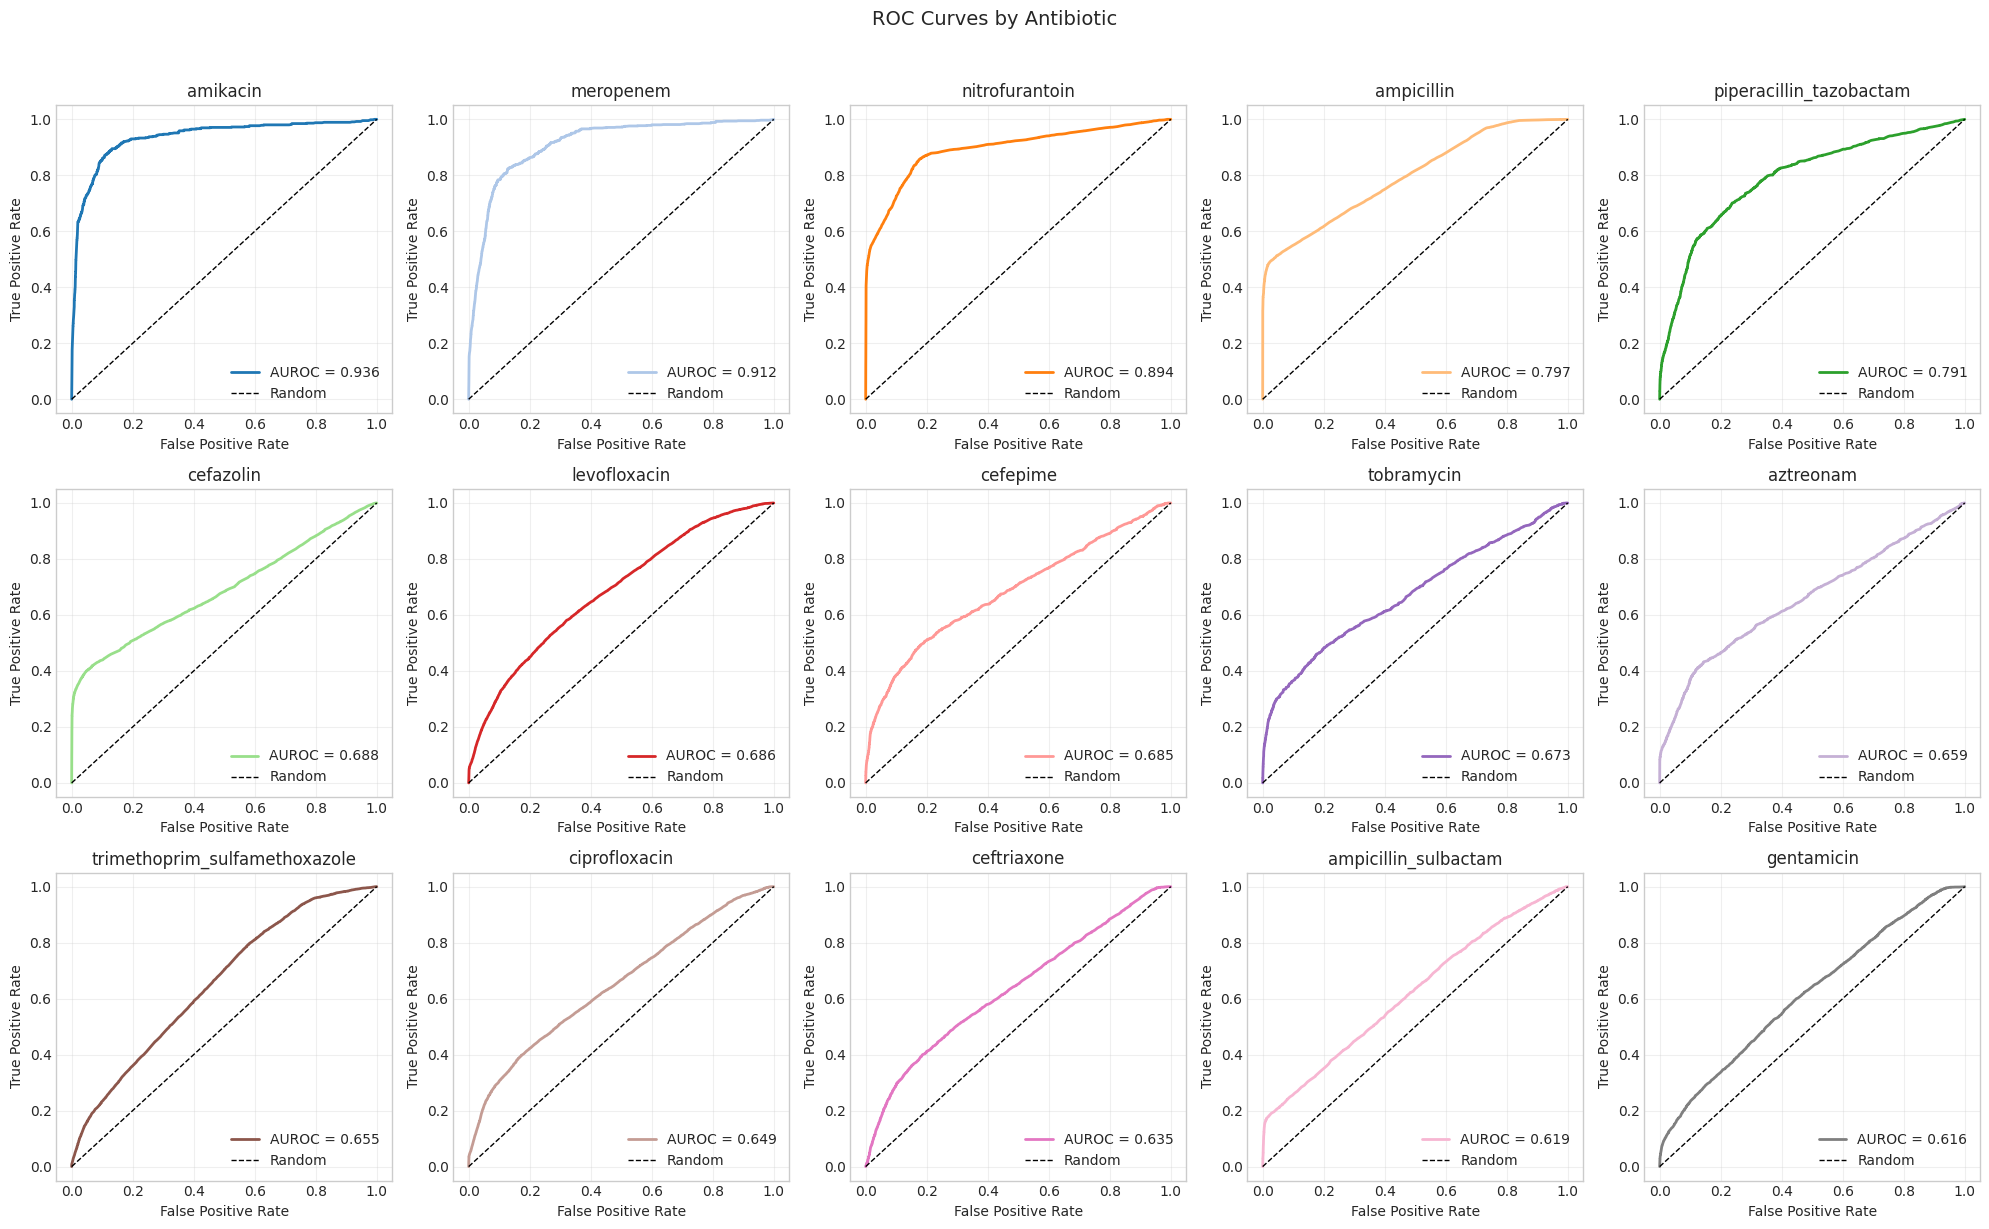

✓ ROC curves saved


In [21]:
# Cell 20: ROC Curves for All Antibiotics

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (abx, r) in enumerate(sorted(training_results.items(), 
                                       key=lambda x: x[1]['auroc'], 
                                       reverse=True)):
    ax = axes[idx]
    
    fpr, tpr, _ = roc_curve(r['y_test'], r['y_pred'])
    
    ax.plot(fpr, tpr, color=COLORS[idx % 20], lw=2, 
            label=f"AUROC = {r['auroc']:.3f}")
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{abx}')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

for idx in range(len(training_results), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('ROC Curves by Antibiotic', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(config.OUTPUT_PATH / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ ROC curves saved")

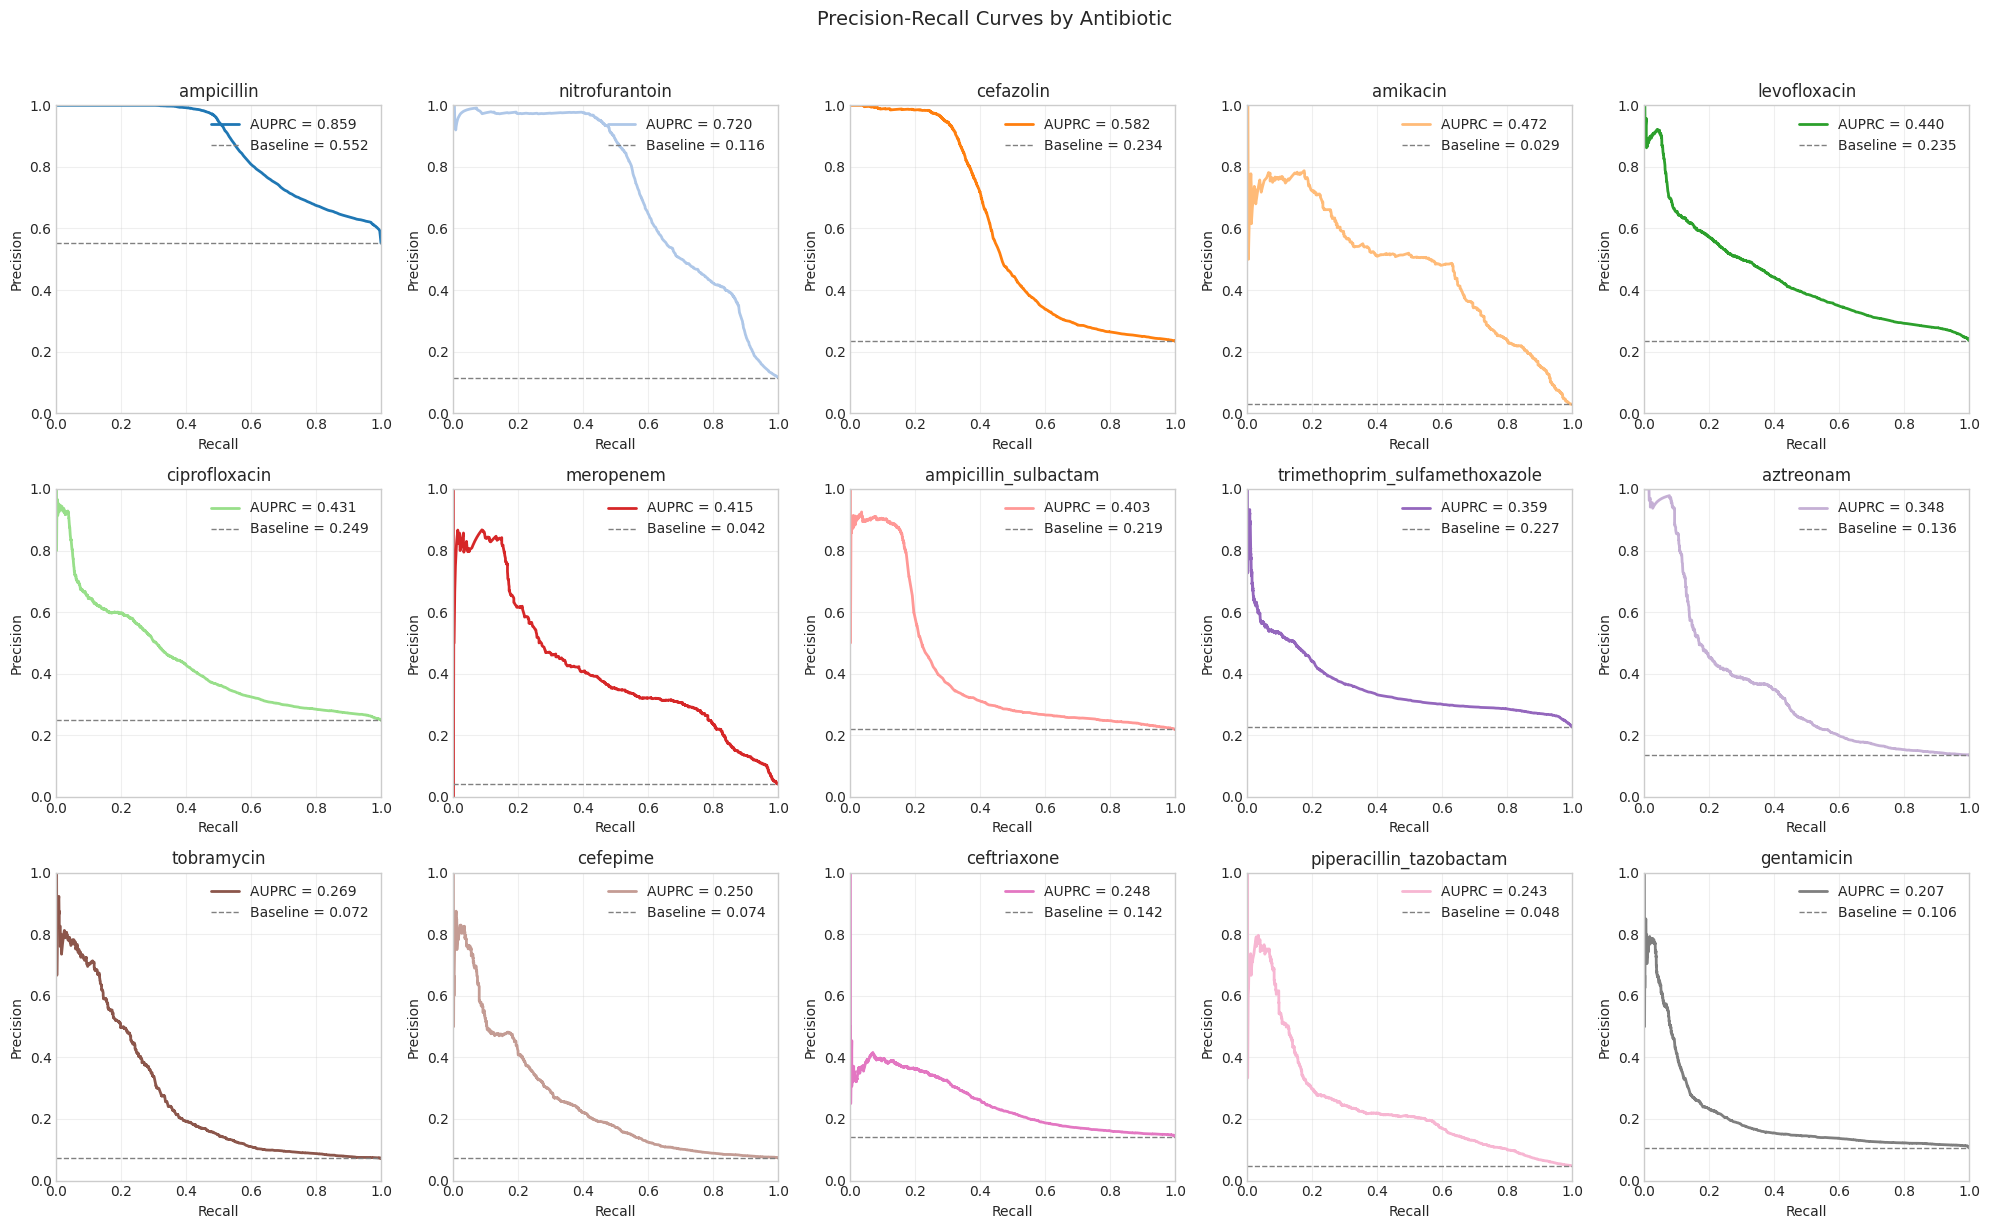

✓ PR curves saved


In [22]:
# Cell 21: Precision-Recall Curves

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, (abx, r) in enumerate(sorted(training_results.items(), 
                                       key=lambda x: x[1]['auprc'], 
                                       reverse=True)):
    ax = axes[idx]
    
    precision, recall, _ = precision_recall_curve(r['y_test'], r['y_pred'])
    baseline = r['test_resistance_rate']
    
    ax.plot(recall, precision, color=COLORS[idx % 20], lw=2, 
            label=f"AUPRC = {r['auprc']:.3f}")
    ax.axhline(y=baseline, color='gray', linestyle='--', lw=1, 
               label=f'Baseline = {baseline:.3f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{abx}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

for idx in range(len(training_results), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Precision-Recall Curves by Antibiotic', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(config.OUTPUT_PATH / 'pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ PR curves saved")

CALIBRATION ANALYSIS


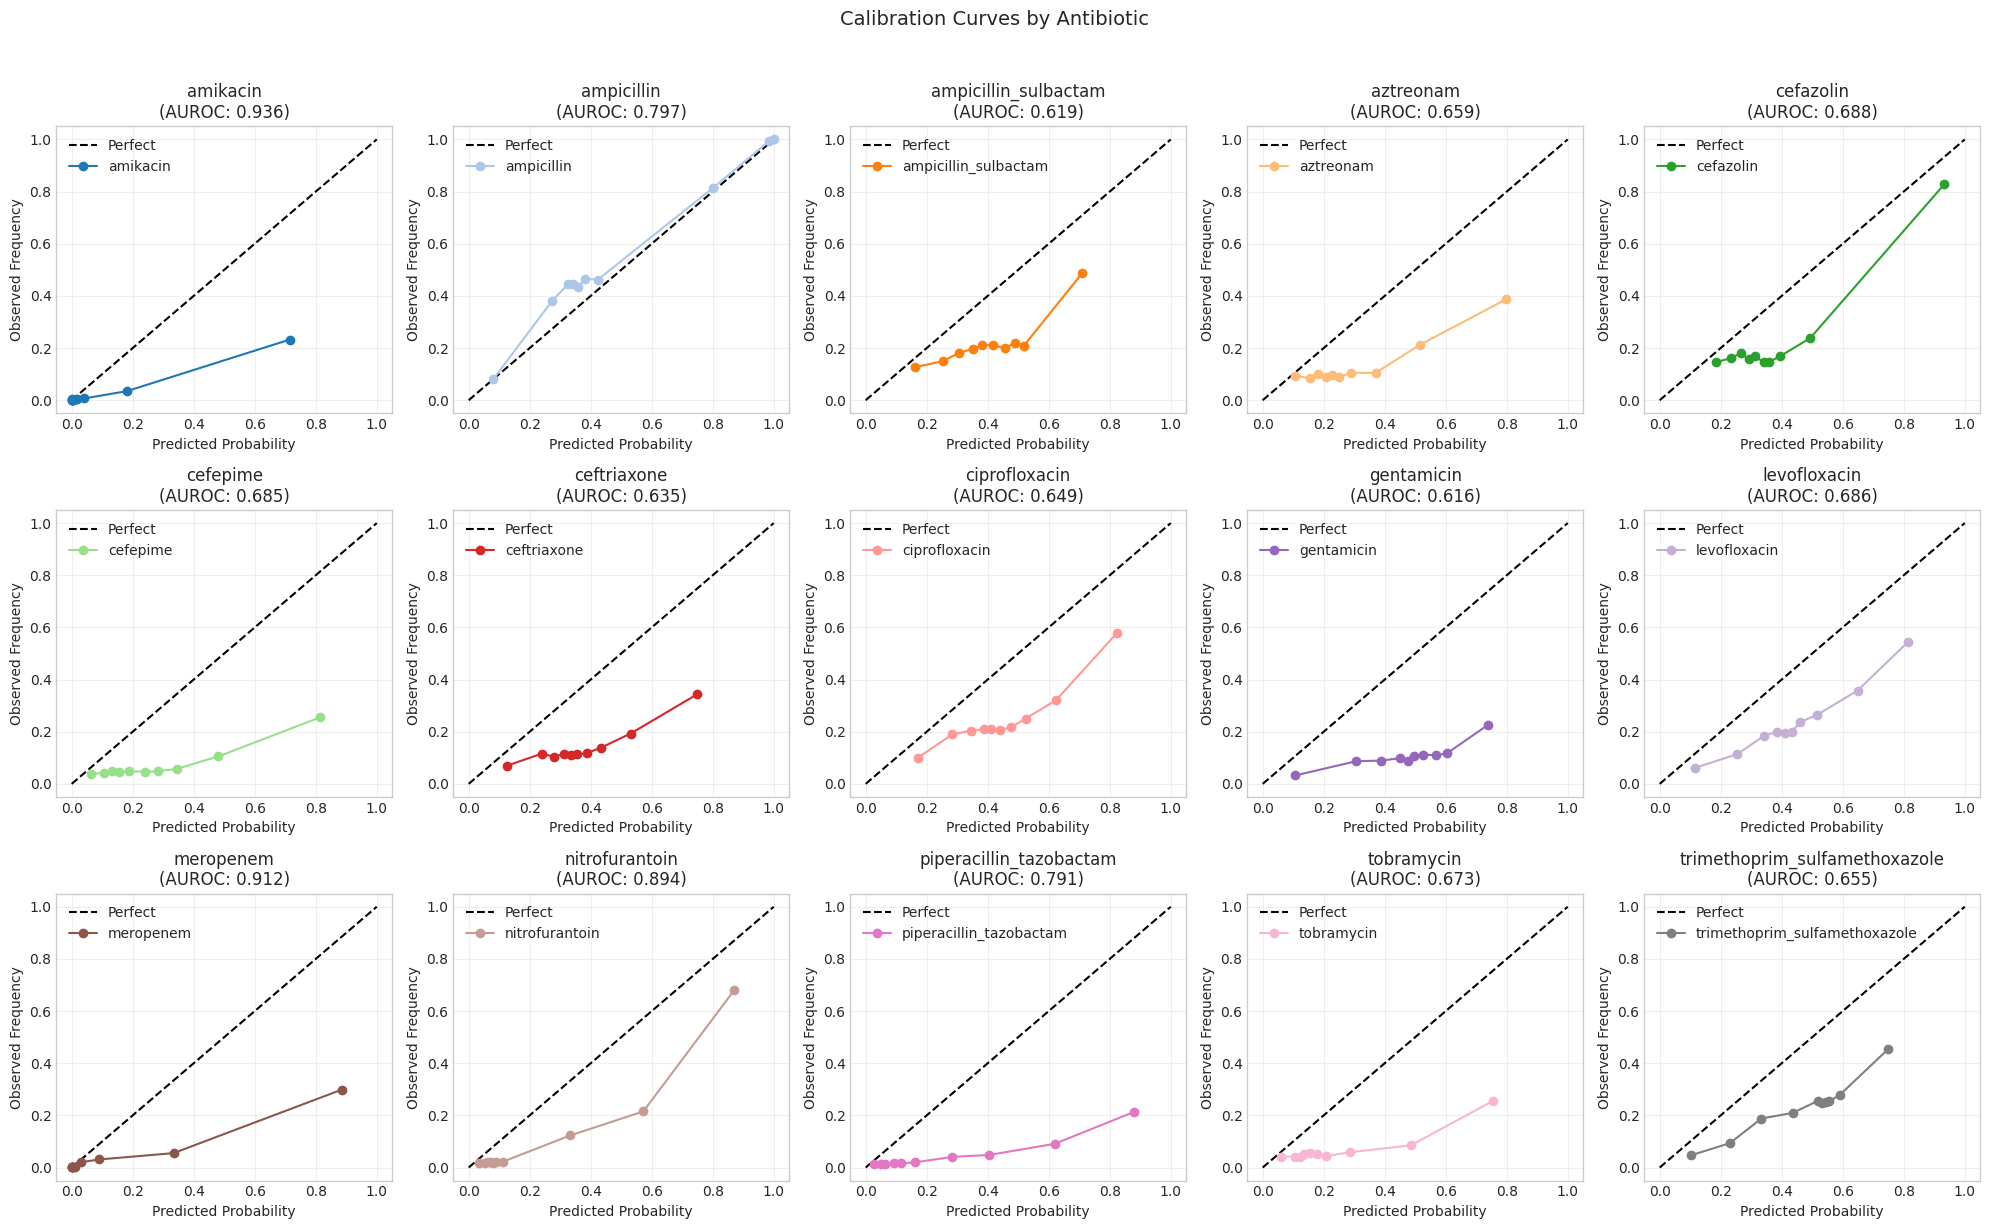


Calibration Error (lower is better):


,Antibiotic,Calibration_Error
1,ampicillin,0.055227
0,amikacin,0.068100
10,meropenem,0.094773
11,nitrofurantoin,0.112509
4,cefazolin,0.146801
3,aztreonam,0.174350
13,tobramycin,0.176202
2,ampicillin_sulbactam,0.185235
7,ciprofloxacin,0.199971
9,levofloxacin,0.202352


In [23]:
# Cell 22: Calibration Analysis

print("="*60)
print("CALIBRATION ANALYSIS")
print("="*60)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

calibration_metrics = []

for idx, (abx, r) in enumerate(sorted(training_results.items())):
    ax = axes[idx]
    
    y_true = r['y_test']
    y_pred = r['y_pred']
    
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy='quantile')
        
        ax.plot([0, 1], [0, 1], 'k--', label='Perfect')
        ax.plot(prob_pred, prob_true, 'o-', color=COLORS[idx % 20], label=abx)
        ax.set_xlabel('Predicted Probability')
        ax.set_ylabel('Observed Frequency')
        ax.set_title(f'{abx}\n(AUROC: {r["auroc"]:.3f})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        calibration_error = np.mean(np.abs(prob_true - prob_pred))
        calibration_metrics.append({
            'Antibiotic': abx,
            'Calibration_Error': calibration_error
        })
    except:
        ax.set_title(f'{abx}\n(Insufficient data)')

for idx in range(len(training_results), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Calibration Curves by Antibiotic', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(config.OUTPUT_PATH / 'calibration_curves.png', dpi=150, bbox_inches='tight')
plt.show()

if calibration_metrics:
    cal_df = pd.DataFrame(calibration_metrics).sort_values('Calibration_Error')
    print("\nCalibration Error (lower is better):")
    display(cal_df)

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features (averaged across all antibiotics):
                         feature  mean_importance
          spec_respiratory_tract         0.088040
              gram_gram_negative         0.069075
            org_escherichia_coli         0.065457
                      spec_urine         0.064500
                      gram_other         0.055158
              gram_gram_positive         0.047081
org_enterobacter_cloacae_complex         0.047064
           org_proteus_mirabilis         0.044547
        org_klebsiella_aerogenes         0.034354
       org_klebsiella_pneumoniae         0.033133
        org_enterococcus_faecium         0.031819
       org_staphylococcus_aureus         0.030399
         org_serratia_marcescens         0.030009
 org_citrobacter_koseri_diversus         0.029650
      org_pseudomonas_aeruginosa         0.028235
org_citrobacter_freundii_complex         0.023031
       org_enterococcus_faecalis         0.021416
org_s

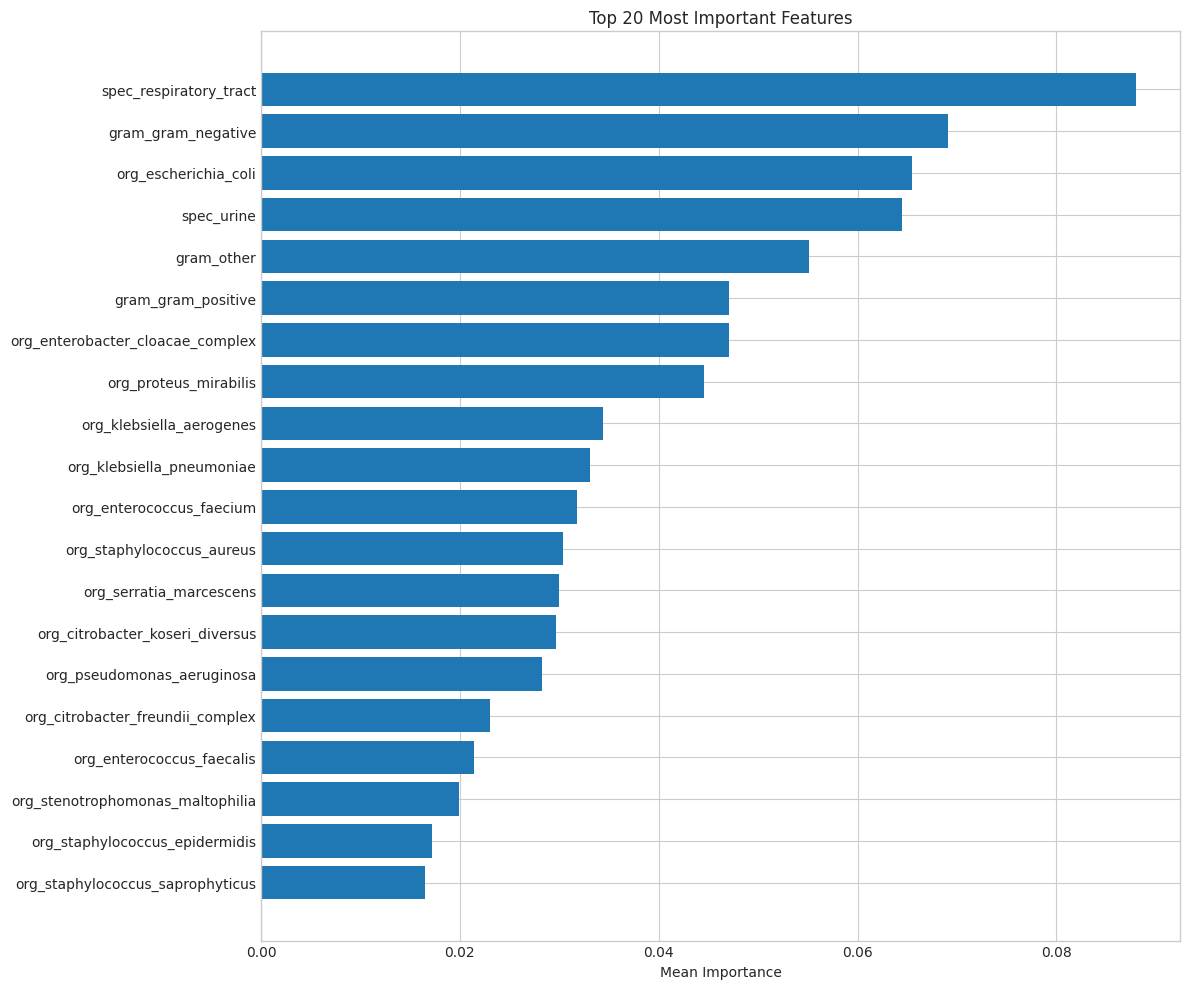


✓ Feature importance saved


In [24]:
# Cell 23: Feature Importance Analysis

print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

importance_matrix = pd.DataFrame({'feature': ALL_FEATURES})

for abx, model in models.items():
    importance_matrix[abx] = model.feature_importances_

importance_matrix['mean_importance'] = importance_matrix[list(models.keys())].mean(axis=1)
importance_matrix = importance_matrix.sort_values('mean_importance', ascending=False)

print("\nTop 20 Most Important Features (averaged across all antibiotics):")
print(importance_matrix[['feature', 'mean_importance']].head(20).to_string(index=False))

print("\n\nImportance by Feature Group:")
group_importance = {}
for group_name, features in FEATURE_GROUPS.items():
    group_imp = importance_matrix[importance_matrix['feature'].isin(features)]['mean_importance'].sum()
    group_importance[group_name] = group_imp
    print(f"  {group_name:20s}: {group_imp:.4f}")

fig, ax = plt.subplots(figsize=(12, 10))
top_20 = importance_matrix.head(20)
bars = ax.barh(range(len(top_20)), top_20['mean_importance'].values)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Mean Importance')
ax.set_title('Top 20 Most Important Features')
plt.tight_layout()
plt.savefig(config.OUTPUT_PATH / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

importance_matrix.to_csv(config.OUTPUT_PATH / 'feature_importance.csv', index=False)
print(f"\n✓ Feature importance saved")

In [25]:
# Cell 24: False Negative Analysis (Clinical Safety)

print("="*60)
print("FALSE NEGATIVE ANALYSIS (CLINICAL SAFETY)")
print("="*60)
print("\nFalse negatives = Predicted 'susceptible' but actually 'resistant'")
print("These are the DANGEROUS errors in clinical practice.\n")

fn_analysis = []

for abx, r in training_results.items():
    y_true = r['y_test']
    y_pred = r['y_pred']
    
    for threshold in [0.1, 0.2, 0.3, 0.5]:
        y_pred_binary = (y_pred >= threshold).astype(int)
        
        tp = ((y_pred_binary == 1) & (y_true == 1)).sum()
        tn = ((y_pred_binary == 0) & (y_true == 0)).sum()
        fp = ((y_pred_binary == 1) & (y_true == 0)).sum()
        fn = ((y_pred_binary == 0) & (y_true == 1)).sum()
        
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        fn_analysis.append({
            'Antibiotic': abx,
            'Threshold': threshold,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'FN_Rate': fnr,
            'FP_Rate': fpr,
            'False_Negatives': fn,
            'True_Positives': tp,
            'Total_Resistant': int(y_true.sum())
        })

fn_df = pd.DataFrame(fn_analysis)

for thresh in [0.3, 0.5]:
    print(f"\n{'='*60}")
    print(f"At {thresh*100:.0f}% threshold (predict resistant if P(R) >= {thresh}):")
    print("="*60)
    
    thresh_df = fn_df[fn_df['Threshold'] == thresh].sort_values('FN_Rate', ascending=False)
    display(thresh_df[['Antibiotic', 'Sensitivity', 'Specificity', 
                       'FN_Rate', 'False_Negatives', 'Total_Resistant']].round(3))

print("\n" + "="*60)
print("CLINICAL RECOMMENDATION")
print("="*60)
print("""
For clinical decision support, consider using a LOWER threshold (e.g., 0.2-0.3) 
to prioritize sensitivity and minimize false negatives (missed resistance).

Trade-off: This increases false positives (unnecessary broad spectrum coverage)
           but reduces risk of treatment failure.
""")

fn_df.to_csv(config.OUTPUT_PATH / 'false_negative_analysis.csv', index=False)

FALSE NEGATIVE ANALYSIS (CLINICAL SAFETY)

False negatives = Predicted 'susceptible' but actually 'resistant'
These are the DANGEROUS errors in clinical practice.


At 30% threshold (predict resistant if P(R) >= 0.3):


,Antibiotic,Sensitivity,Specificity,FN_Rate,False_Negatives,Total_Resistant
54,tobramycin,0.497,0.781,0.503,800,1590
50,aztreonam,0.541,0.701,0.459,810,1764
42,cefepime,0.580,0.706,0.420,703,1673
22,cefazolin,0.723,0.441,0.277,1473,5318
34,piperacillin_tazobactam,0.759,0.685,0.241,336,1397
18,ceftriaxone,0.797,0.318,0.203,729,3589
46,meropenem,0.805,0.885,0.195,189,967
30,ampicillin_sulbactam,0.840,0.265,0.160,574,3588
58,amikacin,0.853,0.903,0.147,97,658
14,nitrofurantoin,0.863,0.816,0.137,443,3233



At 50% threshold (predict resistant if P(R) >= 0.5):


,Antibiotic,Sensitivity,Specificity,FN_Rate,False_Negatives,Total_Resistant
31,ampicillin_sulbactam,0.332,0.819,0.668,2397,3588
19,ceftriaxone,0.344,0.861,0.656,2354,3589
55,tobramycin,0.392,0.874,0.608,966,1590
51,aztreonam,0.396,0.884,0.604,1066,1764
23,cefazolin,0.400,0.952,0.600,3192,5318
43,cefepime,0.405,0.885,0.595,996,1673
7,levofloxacin,0.453,0.795,0.547,4271,7813
3,ciprofloxacin,0.457,0.761,0.543,4220,7772
27,ampicillin,0.504,0.962,0.496,8332,16804
39,gentamicin,0.570,0.579,0.430,1714,3989



CLINICAL RECOMMENDATION

For clinical decision support, consider using a LOWER threshold (e.g., 0.2-0.3) 
to prioritize sensitivity and minimize false negatives (missed resistance).

Trade-off: This increases false positives (unnecessary broad spectrum coverage)
           but reduces risk of treatment failure.



In [26]:
# Cell 25: Generate Predictions for All Test Samples

print("="*60)
print("GENERATING SAMPLE-LEVEL PREDICTIONS")
print("="*60)

test_samples = df_cultures[df_cultures['is_test']].copy()
X_test_all = X[test_mask]

sample_predictions = []

for idx in range(len(test_samples)):
    if idx % 5000 == 0:
        print(f"  Processing sample {idx:,}/{len(test_samples):,}")
    
    sample = test_samples.iloc[idx]
    sample_features = X_test_all.iloc[idx:idx+1]
    
    sample_pred = {
        'sample_idx': idx,
        'culture_id': sample['culture_id'],
        'organism': sample['organism'],
        'specimen_type': sample['specimen_type']
    }
    
    for abx in models.keys():
        target_col = f'resist_{abx}'
        
        if pd.notna(sample[target_col]):
            pred_prob = models[abx].predict_proba(sample_features)[0][1]
            
            sample_pred[f'{abx}_pred'] = pred_prob
            sample_pred[f'{abx}_actual'] = int(sample[target_col])
    
    sample_predictions.append(sample_pred)

predictions_df = pd.DataFrame(sample_predictions)
print(f"\n✓ Generated predictions for {len(predictions_df):,} test samples")

GENERATING SAMPLE-LEVEL PREDICTIONS
  Processing sample 0/40,813
  Processing sample 5,000/40,813
  Processing sample 10,000/40,813
  Processing sample 15,000/40,813
  Processing sample 20,000/40,813
  Processing sample 25,000/40,813
  Processing sample 30,000/40,813
  Processing sample 35,000/40,813
  Processing sample 40,000/40,813

✓ Generated predictions for 40,813 test samples


In [27]:
# Cell 26: Top-K Accuracy with Baseline Comparisons

print("="*60)
print("TOP-K RECOMMENDATION ACCURACY")
print("="*60)
print("\n'Is an effective antibiotic in the top K recommendations?'\n")

def evaluate_top_k(predictions_df, models, k_values=[1, 2, 3, 5]):
    """Evaluate recommendation accuracy for multiple strategies."""
    
    results = {k: {'model': 0, 'random': 0, 'antibiogram': 0, 'total': 0} 
               for k in k_values}
    
    np.random.seed(42)
    
    for _, row in predictions_df.iterrows():
        pred_cols = [c for c in predictions_df.columns if c.endswith('_pred')]
        available_abx = []
        
        for col in pred_cols:
            abx = col.replace('_pred', '')
            actual_col = f'{abx}_actual'
            
            if actual_col in row and pd.notna(row[col]) and pd.notna(row[actual_col]):
                available_abx.append({
                    'antibiotic': abx,
                    'pred_suscept': 1 - row[col],
                    'is_susceptible': row[actual_col] == 0
                })
        
        if len(available_abx) < 3:
            continue
        
        for k in k_values:
            if len(available_abx) < k:
                continue
                
            results[k]['total'] += 1
            
            ranked_model = sorted(available_abx, 
                                 key=lambda x: x['pred_suscept'], 
                                 reverse=True)
            top_k_model = ranked_model[:k]
            model_hit = any(a['is_susceptible'] for a in top_k_model)
            
            random_indices = np.random.choice(len(available_abx), min(k, len(available_abx)), replace=False)
            random_k = [available_abx[i] for i in random_indices]
            random_hit = any(a['is_susceptible'] for a in random_k)
            
            ranked_antibiogram = sorted(available_abx,
                                       key=lambda x: population_susceptibility.get(x['antibiotic'], 0),
                                       reverse=True)
            top_k_antibiogram = ranked_antibiogram[:k]
            antibiogram_hit = any(a['is_susceptible'] for a in top_k_antibiogram)
            
            results[k]['model'] += model_hit
            results[k]['random'] += random_hit
            results[k]['antibiogram'] += antibiogram_hit
    
    return results

top_k_results = evaluate_top_k(predictions_df, models)

print(f"{'K':<4} {'Model':>10} {'Antibiogram':>12} {'Random':>10} {'Model vs Random':>16}")
print("-"*60)

for k, counts in top_k_results.items():
    total = counts['total']
    if total == 0:
        continue
        
    model_acc = counts['model'] / total * 100
    random_acc = counts['random'] / total * 100
    antibiogram_acc = counts['antibiogram'] / total * 100
    model_lift = (model_acc - random_acc)
    
    print(f"{k:<4} {model_acc:>9.1f}% {antibiogram_acc:>11.1f}% {random_acc:>9.1f}% {model_lift:>+15.1f}%")

print(f"\nTotal samples evaluated: {top_k_results[1]['total']:,}")

TOP-K RECOMMENDATION ACCURACY

'Is an effective antibiotic in the top K recommendations?'

K         Model  Antibiogram     Random  Model vs Random
------------------------------------------------------------
1         96.6%        95.6%      81.5%           +15.1%
2         98.2%        98.0%      93.0%            +5.1%
3         98.6%        98.4%      96.6%            +2.0%
5         99.6%        99.1%      99.1%            +0.5%

Total samples evaluated: 38,255


TOP-K DIAGNOSTIC ANALYSIS

Why is Top-K accuracy so high? Let's investigate.

Statistics per sample:
  Mean antibiotics tested: 9.6
  Mean antibiotics susceptible: 7.9
  Mean % susceptible: 82.0%

  Samples with 0 susceptible options: 414 (1.01%)
  Samples with 1 susceptible option: 2,262 (5.54%)
  Samples with 2 susceptible options: 2,997 (7.34%)
  Samples with 3+ susceptible options: 35,140 (86.1%)

CONCLUSION

Most samples (82% on average) are susceptible to most antibiotics.
This means random guessing would also achieve ~82% accuracy.

The true test of the model is:
1. Does it beat the antibiogram baseline?
2. Does it correctly AVOID resistant antibiotics?
3. How does it perform on DIFFICULT cases (few susceptible options)?



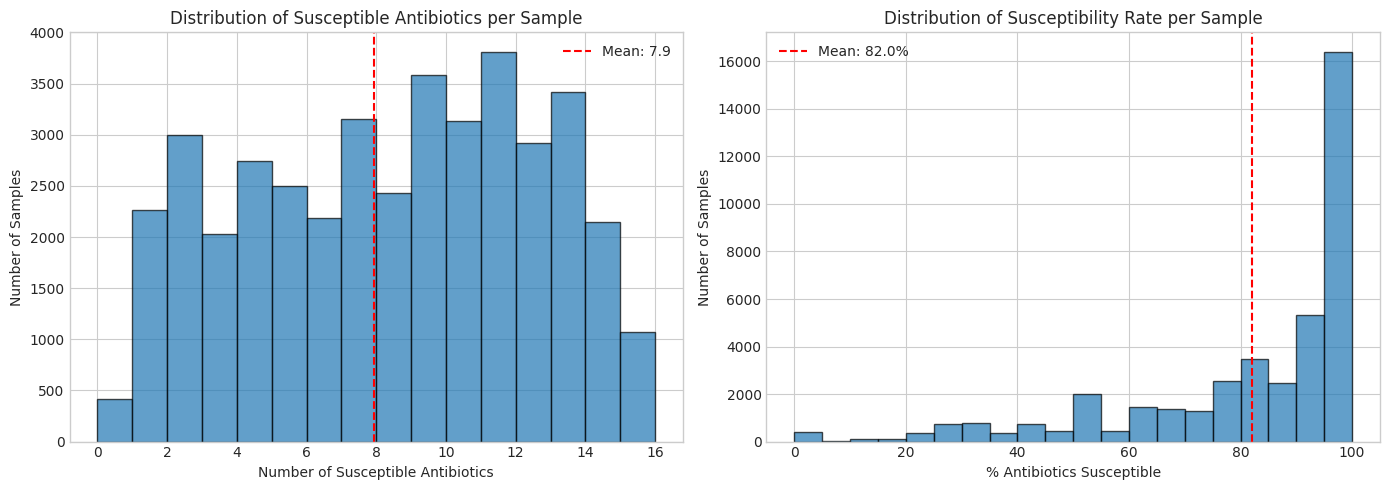

In [28]:
# Cell 27: Analyze Why Top-K is So High (Critical Diagnostic)

print("="*60)
print("TOP-K DIAGNOSTIC ANALYSIS")
print("="*60)
print("\nWhy is Top-K accuracy so high? Let's investigate.\n")

n_susceptible_per_sample = []
n_tested_per_sample = []

for _, row in predictions_df.iterrows():
    pred_cols = [c for c in predictions_df.columns if c.endswith('_pred')]
    available_abx = []
    
    for col in pred_cols:
        abx = col.replace('_pred', '')
        actual_col = f'{abx}_actual'
        
        if actual_col in row and pd.notna(row[actual_col]):
            available_abx.append({
                'antibiotic': abx,
                'is_susceptible': row[actual_col] == 0
            })
    
    if len(available_abx) > 0:
        n_tested = len(available_abx)
        n_susceptible = sum(a['is_susceptible'] for a in available_abx)
        n_susceptible_per_sample.append(n_susceptible)
        n_tested_per_sample.append(n_tested)

n_susceptible_per_sample = np.array(n_susceptible_per_sample)
n_tested_per_sample = np.array(n_tested_per_sample)
pct_susceptible = n_susceptible_per_sample / n_tested_per_sample * 100

print(f"Statistics per sample:")
print(f"  Mean antibiotics tested: {np.mean(n_tested_per_sample):.1f}")
print(f"  Mean antibiotics susceptible: {np.mean(n_susceptible_per_sample):.1f}")
print(f"  Mean % susceptible: {np.mean(pct_susceptible):.1f}%")
print(f"\n  Samples with 0 susceptible options: {(n_susceptible_per_sample == 0).sum():,} ({(n_susceptible_per_sample == 0).mean()*100:.2f}%)")
print(f"  Samples with 1 susceptible option: {(n_susceptible_per_sample == 1).sum():,} ({(n_susceptible_per_sample == 1).mean()*100:.2f}%)")
print(f"  Samples with 2 susceptible options: {(n_susceptible_per_sample == 2).sum():,} ({(n_susceptible_per_sample == 2).mean()*100:.2f}%)")
print(f"  Samples with 3+ susceptible options: {(n_susceptible_per_sample >= 3).sum():,} ({(n_susceptible_per_sample >= 3).mean()*100:.1f}%)")

print(f"\n{'='*60}")
print("CONCLUSION")
print("="*60)
print(f"""
Most samples ({np.mean(pct_susceptible):.0f}% on average) are susceptible to most antibiotics.
This means random guessing would also achieve ~{np.mean(pct_susceptible):.0f}% accuracy.

The true test of the model is:
1. Does it beat the antibiogram baseline?
2. Does it correctly AVOID resistant antibiotics?
3. How does it perform on DIFFICULT cases (few susceptible options)?
""")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(n_susceptible_per_sample, bins=range(0, max(n_tested_per_sample)+2), 
             edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Susceptible Antibiotics')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Distribution of Susceptible Antibiotics per Sample')
axes[0].axvline(x=np.mean(n_susceptible_per_sample), color='red', linestyle='--', 
                label=f'Mean: {np.mean(n_susceptible_per_sample):.1f}')
axes[0].legend()

axes[1].hist(pct_susceptible, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('% Antibiotics Susceptible')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Distribution of Susceptibility Rate per Sample')
axes[1].axvline(x=np.mean(pct_susceptible), color='red', linestyle='--',
                label=f'Mean: {np.mean(pct_susceptible):.1f}%')
axes[1].legend()

plt.tight_layout()
plt.savefig(config.OUTPUT_PATH / 'susceptibility_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [29]:
# Cell 28: Performance on Difficult Cases (Few Susceptible Options)

print("="*60)
print("PERFORMANCE ON DIFFICULT CASES")
print("="*60)
print("\nEvaluating model on samples with limited susceptible options.\n")

def evaluate_difficult_cases(predictions_df, models, max_susceptible=3):
    """Evaluate on cases where <= max_susceptible antibiotics are effective."""
    
    difficult_results = {'model': 0, 'random': 0, 'antibiogram': 0, 'total': 0}
    
    np.random.seed(42)
    
    for _, row in predictions_df.iterrows():
        pred_cols = [c for c in predictions_df.columns if c.endswith('_pred')]
        available_abx = []
        
        for col in pred_cols:
            abx = col.replace('_pred', '')
            actual_col = f'{abx}_actual'
            
            if actual_col in row and pd.notna(row[col]) and pd.notna(row[actual_col]):
                available_abx.append({
                    'antibiotic': abx,
                    'pred_suscept': 1 - row[col],
                    'is_susceptible': row[actual_col] == 0
                })
        
        if len(available_abx) < 3:
            continue
            
        n_susceptible = sum(a['is_susceptible'] for a in available_abx)
        
        if n_susceptible > max_susceptible or n_susceptible == 0:
            continue
        
        difficult_results['total'] += 1
        
        ranked_model = sorted(available_abx, key=lambda x: x['pred_suscept'], reverse=True)
        model_hit = ranked_model[0]['is_susceptible']
        
        random_choice = np.random.choice(available_abx)
        random_hit = random_choice['is_susceptible']
        
        ranked_antibiogram = sorted(available_abx,
                                   key=lambda x: population_susceptibility.get(x['antibiotic'], 0),
                                   reverse=True)
        antibiogram_hit = ranked_antibiogram[0]['is_susceptible']
        
        difficult_results['model'] += model_hit
        difficult_results['random'] += random_hit
        difficult_results['antibiogram'] += antibiogram_hit
    
    return difficult_results

for max_susc in [1, 2, 3]:
    results = evaluate_difficult_cases(predictions_df, models, max_susceptible=max_susc)
    
    if results['total'] > 0:
        print(f"\nSamples with ≤{max_susc} susceptible antibiotics: {results['total']:,}")
        print(f"  Model Top-1 Accuracy:      {results['model']/results['total']*100:>6.1f}%")
        print(f"  Antibiogram Top-1 Accuracy:{results['antibiogram']/results['total']*100:>6.1f}%")
        print(f"  Random Top-1 Accuracy:     {results['random']/results['total']*100:>6.1f}%")
        print(f"  Model Lift vs Random:      {(results['model']-results['random'])/results['total']*100:>+6.1f}%")

PERFORMANCE ON DIFFICULT CASES

Evaluating model on samples with limited susceptible options.


Samples with ≤1 susceptible antibiotics: 1,207
  Model Top-1 Accuracy:        82.9%
  Antibiogram Top-1 Accuracy:  80.9%
  Random Top-1 Accuracy:       23.9%
  Model Lift vs Random:       +59.0%

Samples with ≤2 susceptible antibiotics: 2,801
  Model Top-1 Accuracy:        87.2%
  Antibiogram Top-1 Accuracy:  76.8%
  Random Top-1 Accuracy:       37.3%
  Model Lift vs Random:       +49.9%

Samples with ≤3 susceptible antibiotics: 4,833
  Model Top-1 Accuracy:        89.5%
  Antibiogram Top-1 Accuracy:  81.6%
  Random Top-1 Accuracy:       52.9%
  Model Lift vs Random:       +36.6%


In [30]:
# Cell 29: Performance by Specimen Type

print("="*60)
print("PERFORMANCE BY SPECIMEN TYPE")
print("="*60)

test_with_preds = test_samples.copy().reset_index(drop=True)

for abx in models.keys():
    target_col = f'resist_{abx}'
    pred_col = f'{abx}_pred'
    
    valid_mask = test_with_preds[target_col].notna()
    
    if valid_mask.any():
        X_valid = X_test_all[valid_mask.values]
        preds = models[abx].predict_proba(X_valid)[:, 1]
        test_with_preds.loc[valid_mask, pred_col] = preds

print("\n1. AUROC BY SPECIMEN TYPE:")
print("-"*60)

specimen_results = []

for spec_type in test_with_preds['specimen_type'].unique():
    if pd.isna(spec_type):
        continue
        
    subset = test_with_preds[test_with_preds['specimen_type'] == spec_type]
    
    aurocs = []
    for abx in models.keys():
        target_col = f'resist_{abx}'
        pred_col = f'{abx}_pred'
        
        if pred_col not in subset.columns:
            continue
            
        valid = subset[target_col].notna() & subset[pred_col].notna()
        if valid.sum() > 50:
            y_true = subset.loc[valid, target_col].values
            y_pred = subset.loc[valid, pred_col].values
            
            if len(np.unique(y_true)) > 1:
                aurocs.append(roc_auc_score(y_true, y_pred))
    
    if aurocs:
        specimen_results.append({
            'Specimen': spec_type,
            'Mean_AUROC': np.mean(aurocs),
            'N_Samples': len(subset),
            'N_Antibiotics': len(aurocs)
        })
        print(f"  {spec_type}: Mean AUROC = {np.mean(aurocs):.3f} (n={len(subset):,})")

specimen_df = pd.DataFrame(specimen_results).sort_values('Mean_AUROC', ascending=False)
specimen_df.to_csv(config.OUTPUT_PATH / 'performance_by_specimen.csv', index=False)

PERFORMANCE BY SPECIMEN TYPE

1. AUROC BY SPECIMEN TYPE:
------------------------------------------------------------
  URINE: Mean AUROC = 0.657 (n=29,553)
  RESPIRATORY_TRACT: Mean AUROC = 0.726 (n=5,092)
  BLOOD: Mean AUROC = 0.703 (n=6,168)


In [31]:
# Cell 30: Performance by Organism (Gram Category)

print("="*60)
print("PERFORMANCE BY ORGANISM CATEGORY")
print("="*60)

print("\n1. AUROC BY GRAM CATEGORY:")
print("-"*60)

for gram in ['gram_positive', 'gram_negative', 'other']:
    gram_col = f'gram_{gram}'
    if gram_col not in test_with_preds.columns:
        continue
        
    subset = test_with_preds[test_with_preds[gram_col] == 1]
    
    aurocs = []
    for abx in models.keys():
        target_col = f'resist_{abx}'
        pred_col = f'{abx}_pred'
        
        if pred_col not in subset.columns:
            continue
            
        valid = subset[target_col].notna() & subset[pred_col].notna()
        if valid.sum() > 50:
            y_true = subset.loc[valid, target_col].values
            y_pred = subset.loc[valid, pred_col].values
            
            if len(np.unique(y_true)) > 1:
                aurocs.append(roc_auc_score(y_true, y_pred))
    
    if aurocs:
        print(f"  {gram}: Mean AUROC = {np.mean(aurocs):.3f} (n={len(subset):,})")

print("\n2. AUROC BY TOP ORGANISMS:")
print("-"*60)

org_results = []

for org in top_organisms[:10]:
    subset = test_with_preds[test_with_preds['organism'] == org]
    
    if len(subset) < 100:
        continue
    
    aurocs = []
    for abx in models.keys():
        target_col = f'resist_{abx}'
        pred_col = f'{abx}_pred'
        
        if pred_col not in subset.columns:
            continue
            
        valid = subset[target_col].notna() & subset[pred_col].notna()
        if valid.sum() > 30:
            y_true = subset.loc[valid, target_col].values
            y_pred = subset.loc[valid, pred_col].values
            
            if len(np.unique(y_true)) > 1:
                aurocs.append(roc_auc_score(y_true, y_pred))
    
    if aurocs:
        org_results.append({
            'Organism': org,
            'Mean_AUROC': np.mean(aurocs),
            'N_Samples': len(subset),
            'N_Antibiotics': len(aurocs)
        })

org_df = pd.DataFrame(org_results).sort_values('Mean_AUROC', ascending=False)
display(org_df)
org_df.to_csv(config.OUTPUT_PATH / 'performance_by_organism.csv', index=False)

PERFORMANCE BY ORGANISM CATEGORY

1. AUROC BY GRAM CATEGORY:
------------------------------------------------------------
  gram_positive: Mean AUROC = 0.706 (n=10,728)
  gram_negative: Mean AUROC = 0.679 (n=28,977)
  other: Mean AUROC = 0.757 (n=1,108)

2. AUROC BY TOP ORGANISMS:
------------------------------------------------------------


,Organism,Mean_AUROC,N_Samples,N_Antibiotics
7,ENTEROBACTER CLOACAE COMPLEX,0.586401,794,15
3,PSEUDOMONAS AERUGINOSA,0.578660,2335,15
2,STAPHYLOCOCCUS AUREUS,0.569308,3656,15
1,KLEBSIELLA PNEUMONIAE,0.566544,4003,14
5,PROTEUS MIRABILIS,0.562114,1281,15
0,ESCHERICHIA COLI,0.536231,17690,15
8,COAGULASE NEGATIVE STAPHYLOCOCCUS (OTHER),0.522452,665,8
9,ENTEROCOCCUS FAECIUM,0.498496,573,8
4,ENTEROCOCCUS FAECALIS,0.494785,2251,14
6,STAPHYLOCOCCUS EPIDERMIDIS,0.490349,1105,9


RESISTANCE TRENDS OVER TIME


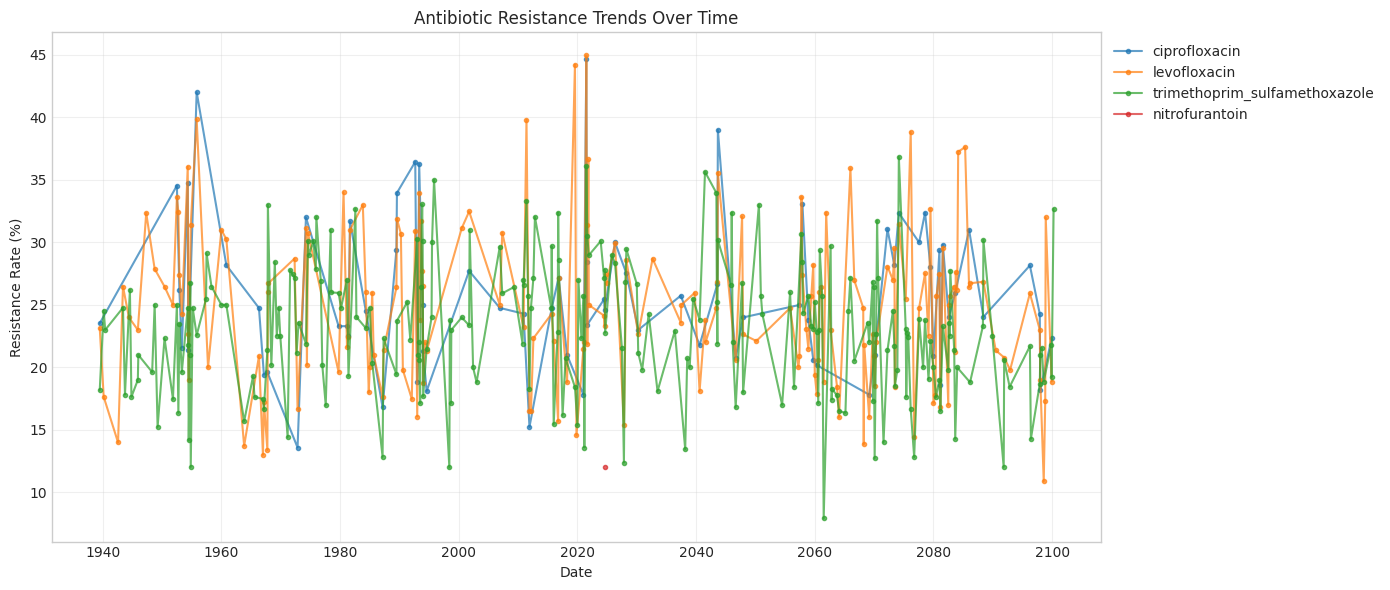

✓ Trend analysis saved


In [32]:
# Cell 31: Resistance Trend Over Time

print("="*60)
print("RESISTANCE TRENDS OVER TIME")
print("="*60)

if 'culture_datetime' in df_cultures.columns:
    df_cultures['year_month'] = df_cultures['culture_datetime'].dt.to_period('M')
    
    trend_data = []
    
    for target_col in TARGET_COLS[:5]:
        abx = target_col.replace('resist_', '')
        
        monthly = df_cultures.groupby('year_month')[target_col].agg(['mean', 'count'])
        monthly = monthly[monthly['count'] >= 100]
        
        for period, row in monthly.iterrows():
            trend_data.append({
                'Period': period.to_timestamp(),
                'Antibiotic': abx,
                'Resistance_Rate': row['mean'],
                'N_Samples': row['count']
            })
    
    trend_df = pd.DataFrame(trend_data)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for abx in trend_df['Antibiotic'].unique():
        abx_data = trend_df[trend_df['Antibiotic'] == abx].sort_values('Period')
        ax.plot(abx_data['Period'], abx_data['Resistance_Rate'] * 100, 
                marker='o', markersize=3, label=abx, alpha=0.7)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Resistance Rate (%)')
    ax.set_title('Antibiotic Resistance Trends Over Time')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(config.OUTPUT_PATH / 'resistance_trends.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Trend analysis saved")
else:
    print("⚠️ No datetime column for trend analysis")

In [33]:
# Cell 32: Clinical Decision Support Function

print("="*60)
print("CLINICAL DECISION SUPPORT SYSTEM")
print("="*60)

def recommend_antibiotics(sample_features, sample_info, models, top_n=5, threshold=0.3):
    """
    Generate antibiotic recommendations for a new culture.
    
    Parameters:
    -----------
    sample_features : pd.DataFrame
        Feature vector for the sample (1 row)
    sample_info : dict
        Dictionary with 'organism' and 'specimen_type'
    models : dict
        Trained models for each antibiotic
    top_n : int
        Number of recommendations to return
    threshold : float
        Probability threshold for warning
    
    Returns:
    --------
    list : Ranked recommendations
    """
    
    predictions = {}
    
    for abx, model in models.items():
        pred_prob = model.predict_proba(sample_features)[0][1]
        predictions[abx] = {
            'resistance_probability': pred_prob,
            'susceptibility_probability': 1 - pred_prob,
            'population_resistance_rate': population_resistance.get(abx, np.nan)
        }
    
    ranked = sorted(predictions.items(), 
                   key=lambda x: x[1]['susceptibility_probability'],
                   reverse=True)
    
    print(f"\n{'='*70}")
    print(f"ANTIBIOTIC SUSCEPTIBILITY PREDICTIONS")
    print(f"{'='*70}")
    print(f"\nOrganism: {sample_info.get('organism', 'Unknown')}")
    print(f"Specimen: {sample_info.get('specimen_type', 'Unknown')}")
    print(f"\n{'Rank':<6}{'Antibiotic':<35}{'P(Susceptible)':<16}{'Risk Level':<12}")
    print("-"*70)
    
    for rank, (abx, info) in enumerate(ranked[:top_n], 1):
        p_susc = info['susceptibility_probability']
        
        if p_susc > 0.85:
            risk = "LOW ✓"
        elif p_susc > 0.70:
            risk = "MODERATE"
        elif p_susc > 0.50:
            risk = "ELEVATED ⚠️"
        else:
            risk = "HIGH ⛔"
        
        print(f"{rank:<6}{abx:<35}{p_susc:>6.1%}{'':>9}{risk:<12}")
    
    print(f"\n{'='*70}")
    print("CLINICAL RECOMMENDATIONS:")
    print("-"*70)
    
    safe_options = [abx for abx, info in ranked if info['susceptibility_probability'] > 0.85]
    if safe_options:
        print(f"✓ CONSIDER: {', '.join(safe_options[:3])}")
    
    high_risk = [abx for abx, info in ranked if info['resistance_probability'] > 0.5]
    if high_risk:
        print(f"⛔ AVOID: {', '.join(high_risk[:3])}")
    
    print(f"\n⚠️  Note: Predictions should be confirmed with culture results.")
    print(f"    Consider local antibiogram and patient-specific factors.")
    print("="*70)
    
    return ranked

example_idx = np.random.randint(0, len(test_samples))
example_sample = test_samples.iloc[example_idx]
example_features = X_test_all.iloc[example_idx:example_idx+1]

example_info = {
    'organism': example_sample.get('organism', 'Unknown'),
    'specimen_type': example_sample.get('specimen_type', 'Unknown')
}

recommendations = recommend_antibiotics(example_features, example_info, models)

CLINICAL DECISION SUPPORT SYSTEM

ANTIBIOTIC SUSCEPTIBILITY PREDICTIONS

Organism: STAPHYLOCOCCUS EPIDERMIDIS
Specimen: BLOOD

Rank  Antibiotic                         P(Susceptible)  Risk Level  
----------------------------------------------------------------------
1     nitrofurantoin                      99.3%         LOW ✓       
2     cefazolin                           79.4%         MODERATE    
3     amikacin                            77.3%         MODERATE    
4     ampicillin_sulbactam                74.7%         MODERATE    
5     cefepime                            72.4%         MODERATE    

CLINICAL RECOMMENDATIONS:
----------------------------------------------------------------------
✓ CONSIDER: nitrofurantoin
⛔ AVOID: piperacillin_tazobactam, meropenem, trimethoprim_sulfamethoxazole

⚠️  Note: Predictions should be confirmed with culture results.
    Consider local antibiogram and patient-specific factors.


In [34]:
# Cell 33: Batch Prediction Function

def batch_predict(X_new, sample_info_df, models, features):
    """
    Generate predictions for multiple samples.
    
    Parameters:
    -----------
    X_new : pd.DataFrame
        Feature matrix for new samples
    sample_info_df : pd.DataFrame
        DataFrame with sample metadata (organism, specimen_type, etc.)
    models : dict
        Trained models
    features : list
        List of feature names
    
    Returns:
    --------
    pd.DataFrame : Predictions for all samples and antibiotics
    """
    
    results = []
    
    for idx in range(len(X_new)):
        sample_features = X_new.iloc[idx:idx+1]
        
        row = {'sample_idx': idx}
        
        if sample_info_df is not None:
            row['organism'] = sample_info_df.iloc[idx].get('organism', 'Unknown')
            row['specimen_type'] = sample_info_df.iloc[idx].get('specimen_type', 'Unknown')
        
        for abx, model in models.items():
            pred_prob = model.predict_proba(sample_features)[0][1]
            row[f'{abx}_resistance_prob'] = pred_prob
            row[f'{abx}_suscept_prob'] = 1 - pred_prob
        
        results.append(row)
    
    return pd.DataFrame(results)

print("✓ Batch prediction function defined")
print("\nUsage:")
print("  predictions = batch_predict(X_new, sample_info, models, ALL_FEATURES)")

✓ Batch prediction function defined

Usage:
  predictions = batch_predict(X_new, sample_info, models, ALL_FEATURES)


In [35]:
# Cell 34: Export Final Summary

print("="*60)
print("FINAL EXPORT")
print("="*60)

summary = {
    'pipeline_version': '1.0',
    'training_date': datetime.now().isoformat(),
    'n_models': len(models),
    'n_features': len(ALL_FEATURES),
    'feature_groups': {k: len(v) for k, v in FEATURE_GROUPS.items()},
    'train_samples': int(train_mask.sum()),
    'test_samples': int(test_mask.sum()),
    'train_date_range': {
        'start': str(train_dates.min().date()),
        'end': str(train_dates.max().date())
    },
    'test_date_range': {
        'start': str(test_dates.min().date()),
        'end': str(test_dates.max().date())
    },
    'performance': perf_df.to_dict('records'),
    'population_resistance': population_resistance,
    'antibiogram_ranking': ANTIBIOGRAM_RANKING,
    'top_k_results': {str(k): v for k, v in top_k_results.items()}
}

with open(config.OUTPUT_PATH / 'pipeline_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"\nFiles saved to {config.OUTPUT_PATH}:")
print(f"  ✓ resistance_models.pkl - Trained models")
print(f"  ✓ model_performance.csv - Performance metrics")
print(f"  ✓ feature_importance.csv - Feature importance scores")
print(f"  ✓ false_negative_analysis.csv - Clinical safety analysis")
print(f"  ✓ performance_by_specimen.csv - Specimen-stratified results")
print(f"  ✓ performance_by_organism.csv - Organism-stratified results")
print(f"  ✓ pipeline_summary.json - Complete pipeline metadata")
print(f"  ✓ roc_curves.png - ROC curve plots")
print(f"  ✓ pr_curves.png - Precision-recall plots")
print(f"  ✓ calibration_curves.png - Calibration plots")
print(f"  ✓ feature_importance.png - Feature importance plot")
print(f"  ✓ susceptibility_distribution.png - Susceptibility distribution")
print(f"  ✓ resistance_trends.png - Temporal trends")

print(f"\n{'='*60}")
print("PIPELINE COMPLETE")
print("="*60)

FINAL EXPORT

Files saved to /workspace/armd-mgb/outputs:
  ✓ resistance_models.pkl - Trained models
  ✓ model_performance.csv - Performance metrics
  ✓ feature_importance.csv - Feature importance scores
  ✓ false_negative_analysis.csv - Clinical safety analysis
  ✓ performance_by_specimen.csv - Specimen-stratified results
  ✓ performance_by_organism.csv - Organism-stratified results
  ✓ pipeline_summary.json - Complete pipeline metadata
  ✓ roc_curves.png - ROC curve plots
  ✓ pr_curves.png - Precision-recall plots
  ✓ calibration_curves.png - Calibration plots
  ✓ feature_importance.png - Feature importance plot
  ✓ susceptibility_distribution.png - Susceptibility distribution
  ✓ resistance_trends.png - Temporal trends

PIPELINE COMPLETE


In [55]:
import gradio as gr
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import io
from PIL import Image
from datetime import datetime

print("=" * 60)
print("🚀 LAUNCHING ULTRA-MODERN CLINICAL DECISION SUPPORT INTERFACE")
print("=" * 60)

# ============================================================
# LOAD MODELS AND CONFIGURATION
# ============================================================

model_path = config.OUTPUT_PATH / 'resistance_models.pkl'

if model_path.exists():
    with open(model_path, 'rb') as f:
        model_package = pickle.load(f)

    loaded_models = model_package['models']
    loaded_features = model_package['features']
    loaded_feature_groups = model_package['feature_groups']
    loaded_population_resistance = model_package['population_resistance']
    print(f"✓ Loaded {len(loaded_models)} models")
else:
    loaded_models = models
    loaded_features = ALL_FEATURES
    loaded_feature_groups = FEATURE_GROUPS
    loaded_population_resistance = population_resistance
    print(f"✓ Using {len(loaded_models)} models from current session")

# Get unique values for dropdowns
ORGANISM_OPTIONS = [''] + top_organisms + ['Other']
SPECIMEN_OPTIONS = [''] + list(df_cultures['specimen_type'].dropna().unique())
GENDER_OPTIONS = ['', 'Female', 'Male', 'Unknown']
AGE_GROUP_OPTIONS = ['', 'Pediatric (0-18)', 'Young Adult (19-40)',
                     'Middle Age (41-65)', 'Senior (66-80)', 'Elderly (80+)']

# ============================================================
# CUSTOM CSS - ULTRA MODERN DESIGN
# ============================================================

CUSTOM_CSS = """
@import url('https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700;800&family=Space+Grotesk:wght@400;500;600;700&display=swap');

:root {
    --primary-gradient: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    --secondary-gradient: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
    --success-gradient: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);
    --warning-gradient: linear-gradient(135deg, #F2994A 0%, #F2C94C 100%);
    --danger-gradient: linear-gradient(135deg, #eb3349 0%, #f45c43 100%);
    --dark-bg: #0a0a0f;
    --card-bg: rgba(255, 255, 255, 0.03);
    --glass-bg: rgba(255, 255, 255, 0.05);
    --glass-border: rgba(255, 255, 255, 0.1);
    --text-primary: #ffffff;
    --text-secondary: rgba(255, 255, 255, 0.7);
    --accent-blue: #4facfe;
    --accent-purple: #667eea;
    --accent-pink: #f093fb;
    --accent-cyan: #00f2fe;
}

.gradio-container {
    max-width: 1400px !important;
    margin: 0 auto !important;
    background: var(--dark-bg) !important;
    font-family: 'Inter', sans-serif !important;
    min-height: 100vh;
}

.dark {
    --background-fill-primary: var(--dark-bg) !important;
    --background-fill-secondary: #12121a !important;
}

.main-container {
    position: relative;
    overflow: hidden;
}

.main-container::before {
    content: '';
    position: fixed;
    top: 0; left: 0; right: 0; bottom: 0;
    background:
        radial-gradient(ellipse at 20% 20%, rgba(102, 126, 234, 0.15) 0%, transparent 50%),
        radial-gradient(ellipse at 80% 80%, rgba(118, 75, 162, 0.15) 0%, transparent 50%),
        radial-gradient(ellipse at 40% 60%, rgba(240, 147, 251, 0.1) 0%, transparent 40%),
        var(--dark-bg);
    z-index: -1;
    animation: gradientShift 20s ease-in-out infinite;
}

@keyframes gradientShift {
    0%, 100% { opacity: 1; }
    50% { opacity: 0.8; }
}

.header-container {
    background: linear-gradient(135deg, rgba(102, 126, 234, 0.2) 0%, rgba(118, 75, 162, 0.2) 100%);
    border: 1px solid var(--glass-border);
    border-radius: 24px;
    padding: 40px;
    margin-bottom: 30px;
    backdrop-filter: blur(20px);
    -webkit-backdrop-filter: blur(20px);
    position: relative;
    overflow: hidden;
}

.header-container::before {
    content: '';
    position: absolute;
    top: -50%; left: -50%;
    width: 200%; height: 200%;
    background: linear-gradient(45deg, transparent 30%, rgba(255,255,255,0.03) 50%, transparent 70%);
    animation: shimmer 8s linear infinite;
}

@keyframes shimmer {
    0% { transform: translateX(-50%) translateY(-50%) rotate(0deg); }
    100% { transform: translateX(-50%) translateY(-50%) rotate(360deg); }
}

.main-title {
    font-family: 'Space Grotesk', sans-serif !important;
    font-size: 3.5rem !important;
    font-weight: 700 !important;
    background: linear-gradient(135deg, #fff 0%, #a5b4fc 50%, #f0abfc 100%);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;
    margin-bottom: 16px !important;
    letter-spacing: -0.02em;
    line-height: 1.1 !important;
}

.subtitle {
    font-size: 1.25rem !important;
    color: var(--text-secondary) !important;
    font-weight: 400 !important;
    max-width: 600px;
}

.glass-card {
    background: var(--glass-bg) !important;
    border: 1px solid var(--glass-border) !important;
    border-radius: 20px !important;
    padding: 28px !important;
    backdrop-filter: blur(20px) !important;
    -webkit-backdrop-filter: blur(20px) !important;
    transition: all 0.4s cubic-bezier(0.4, 0, 0.2, 1) !important;
    position: relative;
    overflow: hidden;
}

.glass-card:hover {
    border-color: rgba(255, 255, 255, 0.2) !important;
    transform: translateY(-4px);
    box-shadow: 0 20px 40px rgba(0,0,0,0.3), 0 0 60px rgba(102,126,234,0.1);
}

.glass-card::before {
    content: '';
    position: absolute;
    top: 0; left: 0; right: 0;
    height: 1px;
    background: linear-gradient(90deg, transparent, rgba(255,255,255,0.2), transparent);
}

.section-header {
    display: flex;
    align-items: center;
    gap: 12px;
    margin-bottom: 24px;
    padding-bottom: 16px;
    border-bottom: 1px solid var(--glass-border);
}

.section-icon {
    width: 48px; height: 48px;
    border-radius: 14px;
    display: flex; align-items: center; justify-content: center;
    font-size: 24px;
    background: var(--primary-gradient);
    box-shadow: 0 8px 24px rgba(102, 126, 234, 0.3);
}

.section-title {
    font-family: 'Space Grotesk', sans-serif !important;
    font-size: 1.5rem !important;
    font-weight: 600 !important;
    color: var(--text-primary) !important;
    margin: 0 !important;
}

.gradio-dropdown > label > div > div > input,
.gradio-dropdown > label > div > div > select {
    background: rgba(255,255,255,0.05) !important;
    border: 2px solid rgba(255,255,255,0.1) !important;
    border-radius: 14px !important;
    color: white !important;
    font-size: 15px !important;
    padding: 16px 20px !important;
    transition: all 0.3s ease !important;
    font-family: 'Inter', sans-serif !important;
}

.gradio-dropdown > label > div > div > input:focus,
.gradio-dropdown > label > div > div > select:focus {
    border-color: var(--accent-purple) !important;
    box-shadow: 0 0 0 4px rgba(102, 126, 234, 0.15) !important;
    outline: none !important;
}

.gradio-dropdown > label > span {
    color: var(--text-primary) !important;
    font-weight: 600 !important;
    font-size: 14px !important;
    margin-bottom: 8px !important;
    display: block !important;
}

.gradio-number input {
    background: rgba(255,255,255,0.05) !important;
    border: 2px solid rgba(255,255,255,0.1) !important;
    border-radius: 14px !important;
    color: white !important;
    font-size: 15px !important;
    padding: 16px 20px !important;
    transition: all 0.3s ease !important;
}

.gradio-number input:focus {
    border-color: var(--accent-purple) !important;
    box-shadow: 0 0 0 4px rgba(102, 126, 234, 0.15) !important;
}

.gradio-number > label > span {
    color: var(--text-primary) !important;
    font-weight: 600 !important;
    font-size: 14px !important;
}

.primary-btn {
    background: var(--primary-gradient) !important;
    border: none !important;
    border-radius: 16px !important;
    color: white !important;
    font-weight: 600 !important;
    font-size: 16px !important;
    padding: 18px 32px !important;
    cursor: pointer !important;
    transition: all 0.4s cubic-bezier(0.4, 0, 0.2, 1) !important;
    position: relative !important;
    overflow: hidden !important;
    text-transform: uppercase !important;
    letter-spacing: 0.5px !important;
    box-shadow: 0 8px 32px rgba(102, 126, 234, 0.35) !important;
}

.primary-btn::before {
    content: '';
    position: absolute;
    top: 0; left: -100%;
    width: 100%; height: 100%;
    background: linear-gradient(90deg, transparent, rgba(255,255,255,0.2), transparent);
    transition: left 0.6s ease;
}

.primary-btn:hover::before { left: 100%; }

.primary-btn:hover {
    transform: translateY(-3px) scale(1.02) !important;
    box-shadow: 0 12px 40px rgba(102,126,234,0.45), 0 0 60px rgba(102,126,234,0.2) !important;
}

.primary-btn:active {
    transform: translateY(-1px) scale(0.98) !important;
}

.secondary-btn {
    background: rgba(255,255,255,0.05) !important;
    border: 2px solid rgba(255,255,255,0.2) !important;
    border-radius: 16px !important;
    color: white !important;
    font-weight: 500 !important;
    font-size: 15px !important;
    padding: 16px 24px !important;
    cursor: pointer !important;
    transition: all 0.3s ease !important;
}

.secondary-btn:hover {
    background: rgba(255,255,255,0.1) !important;
    border-color: rgba(255,255,255,0.3) !important;
    transform: translateY(-2px) !important;
}

.example-btn {
    background: linear-gradient(135deg, rgba(102,126,234,0.2) 0%, rgba(118,75,162,0.2) 100%) !important;
    border: 1px solid rgba(255,255,255,0.15) !important;
    border-radius: 50px !important;
    color: white !important;
    font-weight: 500 !important;
    font-size: 14px !important;
    padding: 14px 28px !important;
    cursor: pointer !important;
    transition: all 0.3s ease !important;
    backdrop-filter: blur(10px) !important;
}

.example-btn:hover {
    background: linear-gradient(135deg, rgba(102,126,234,0.4) 0%, rgba(118,75,162,0.4) 100%) !important;
    border-color: var(--accent-purple) !important;
    transform: translateY(-2px) scale(1.02) !important;
    box-shadow: 0 8px 24px rgba(102,126,234,0.3) !important;
}

.tabs { background: transparent !important; border: none !important; }

.tab-nav {
    background: rgba(255,255,255,0.03) !important;
    border-radius: 16px !important;
    padding: 6px !important;
    gap: 4px !important;
    border: 1px solid var(--glass-border) !important;
}

.tab-nav button {
    border-radius: 12px !important;
    padding: 14px 24px !important;
    font-weight: 500 !important;
    color: var(--text-secondary) !important;
    background: transparent !important;
    border: none !important;
    transition: all 0.3s ease !important;
    font-size: 14px !important;
}

.tab-nav button:hover {
    color: white !important;
    background: rgba(255,255,255,0.05) !important;
}

.tab-nav button.selected {
    background: var(--primary-gradient) !important;
    color: white !important;
    box-shadow: 0 4px 16px rgba(102,126,234,0.3) !important;
}

.dataframe {
    background: rgba(255,255,255,0.02) !important;
    border: 1px solid var(--glass-border) !important;
    border-radius: 16px !important;
    overflow: hidden !important;
}

.dataframe thead {
    background: linear-gradient(135deg, rgba(102,126,234,0.2) 0%, rgba(118,75,162,0.2) 100%) !important;
}

.dataframe th {
    color: white !important;
    font-weight: 600 !important;
    padding: 16px !important;
    text-transform: uppercase !important;
    font-size: 12px !important;
    letter-spacing: 0.5px !important;
    border: none !important;
}

.dataframe td {
    color: var(--text-secondary) !important;
    padding: 14px 16px !important;
    border-bottom: 1px solid var(--glass-border) !important;
    font-size: 14px !important;
}

.dataframe tr:hover td {
    background: rgba(255,255,255,0.03) !important;
    color: white !important;
}

.image-container {
    border-radius: 20px !important;
    overflow: hidden !important;
    border: 1px solid var(--glass-border) !important;
    background: rgba(255,255,255,0.02) !important;
}

.markdown-body { color: var(--text-secondary) !important; line-height: 1.7 !important; }
.markdown-body h2 { color: white !important; font-family: 'Space Grotesk', sans-serif !important; font-weight: 600 !important; margin-top: 24px !important; }
.markdown-body h3 { color: var(--text-primary) !important; font-family: 'Space Grotesk', sans-serif !important; font-weight: 600 !important; }
.markdown-body strong { color: white !important; }
.markdown-body code { background: rgba(255,255,255,0.1) !important; padding: 2px 8px !important; border-radius: 6px !important; color: var(--accent-cyan) !important; }

@keyframes pulse { 0%, 100% { opacity: 1; } 50% { opacity: 0.5; } }
.loading { animation: pulse 1.5s ease-in-out infinite; }

@media (max-width: 768px) {
    .main-title { font-size: 2rem !important; }
    .header-container { padding: 24px !important; }
    .glass-card { padding: 20px !important; }
}

::-webkit-scrollbar { width: 10px; height: 10px; }
::-webkit-scrollbar-track { background: rgba(255,255,255,0.02); border-radius: 5px; }
::-webkit-scrollbar-thumb { background: linear-gradient(180deg, var(--accent-purple), var(--accent-pink)); border-radius: 5px; }
::-webkit-scrollbar-thumb:hover { background: linear-gradient(180deg, var(--accent-pink), var(--accent-purple)); }

.footer {
    margin-top: 40px;
    padding: 30px;
    text-align: center;
    border-top: 1px solid var(--glass-border);
    color: var(--text-secondary);
    font-size: 13px;
}

.fade-in { animation: fadeIn 0.6s ease-out; }
@keyframes fadeIn { from { opacity: 0; transform: translateY(20px); } to { opacity: 1; transform: translateY(0); } }

.slide-in-left { animation: slideInLeft 0.5s ease-out; }
@keyframes slideInLeft { from { opacity: 0; transform: translateX(-30px); } to { opacity: 1; transform: translateX(0); } }

.slide-in-right { animation: slideInRight 0.5s ease-out; }
@keyframes slideInRight { from { opacity: 0; transform: translateX(30px); } to { opacity: 1; transform: translateX(0); } }
"""

# ============================================================
# ENHANCED VISUALIZATION FUNCTION
# ============================================================

def create_enhanced_visualization(predictions, organism, specimen_type):
    """Create a stunning visualization of predictions."""

    plt.style.use('dark_background')

    fig = plt.figure(figsize=(14, 10))
    fig.patch.set_facecolor('#0a0a0f')

    gs = fig.add_gridspec(2, 3, height_ratios=[2, 1], hspace=0.35, wspace=0.3)

    # Main horizontal bar chart
    ax1 = fig.add_subplot(gs[0, :])

    top_12 = predictions[:12]
    antibiotics = [p['Antibiotic'] for p in top_12]
    suscept_probs = [p['prob_susceptible'] * 100 for p in top_12]

    colors = []
    for p in top_12:
        prob = p['prob_susceptible']
        if prob > 0.85:
            colors.append('#38ef7d')
        elif prob > 0.70:
            colors.append('#F2C94C')
        elif prob > 0.50:
            colors.append('#F2994A')
        else:
            colors.append('#f45c43')

    bars = ax1.barh(range(len(antibiotics)), suscept_probs,
                    color=colors, height=0.7,
                    edgecolor='white', linewidth=0.5, alpha=0.9)

    for bar, color in zip(bars, colors):
        ax1.barh(bar.get_y() + bar.get_height() / 2, bar.get_width(),
                 height=bar.get_height() * 1.5, color=color, alpha=0.1)

    ax1.set_yticks(range(len(antibiotics)))
    ax1.set_yticklabels(antibiotics, fontsize=12, fontweight='500', color='white')
    ax1.set_xlabel('Predicted Susceptibility (%)', fontsize=13, fontweight='600',
                   color='white', labelpad=15)
    ax1.set_xlim(0, 105)

    ax1.set_title('🔬 Antibiotic Susceptibility Profile',
                  fontsize=20, fontweight='700', color='white', pad=25,
                  fontfamily='sans-serif')
    ax1.text(50, -1.5, f'{organism} • {specimen_type}',
             ha='center', fontsize=12, color='#a5b4fc', style='italic')

    ax1.axvline(x=85, color='#38ef7d', linestyle='--', alpha=0.6, linewidth=2)
    ax1.axvline(x=70, color='#F2C94C', linestyle='--', alpha=0.6, linewidth=2)
    ax1.axvline(x=50, color='#f45c43', linestyle='--', alpha=0.6, linewidth=2)

    ax1.text(86, len(antibiotics) - 0.5, 'Low Risk', fontsize=9, color='#38ef7d', va='top')
    ax1.text(71, len(antibiotics) - 0.5, 'Moderate', fontsize=9, color='#F2C94C', va='top')
    ax1.text(51, len(antibiotics) - 0.5, 'High Risk', fontsize=9, color='#f45c43', va='top')

    for i, (bar, prob) in enumerate(zip(bars, suscept_probs)):
        ax1.text(prob + 2, i, f'{prob:.0f}%', va='center', fontsize=11,
                 fontweight='600', color='white')

    ax1.invert_yaxis()
    ax1.set_facecolor('#0a0a0f')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_color('#333')
    ax1.spines['bottom'].set_color('#333')
    ax1.tick_params(colors='white')
    ax1.grid(axis='x', alpha=0.15, color='white')

    # Risk Distribution Pie Chart
    ax2 = fig.add_subplot(gs[1, 0])

    risk_counts = {'Low': 0, 'Moderate': 0, 'Elevated': 0, 'High': 0}
    for p in predictions:
        if p['risk_score'] == 1:
            risk_counts['Low'] += 1
        elif p['risk_score'] == 2:
            risk_counts['Moderate'] += 1
        elif p['risk_score'] == 3:
            risk_counts['Elevated'] += 1
        else:
            risk_counts['High'] += 1

    pie_colors = ['#38ef7d', '#F2C94C', '#F2994A', '#f45c43']
    wedges, texts, autotexts = ax2.pie(
        risk_counts.values(),
        labels=risk_counts.keys(),
        colors=pie_colors,
        autopct='%1.0f%%',
        startangle=90,
        explode=(0.05, 0.02, 0.02, 0.05),
        shadow=True,
        textprops={'color': 'white', 'fontsize': 10}
    )
    ax2.set_title('Risk Distribution', fontsize=14, fontweight='600', color='white', pad=15)

    # Top Recommendations
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_facecolor('#0a0a0f')
    ax3.axis('off')

    ax3.text(0.5, 0.95, '✅ TOP RECOMMENDATIONS', fontsize=13, fontweight='700',
             color='white', ha='center', transform=ax3.transAxes)

    for i, pred in enumerate(predictions[:3]):
        y_pos = 0.75 - i * 0.25
        ax3.text(0.1, y_pos, f"{i + 1}.", fontsize=14, fontweight='700',
                 color='#38ef7d', transform=ax3.transAxes)
        ax3.text(0.2, y_pos, pred['Antibiotic'], fontsize=12, fontweight='600',
                 color='white', transform=ax3.transAxes)
        ax3.text(0.2, y_pos - 0.08, f"{pred['prob_susceptible'] * 100:.0f}% susceptible",
                 fontsize=10, color='#a5b4fc', transform=ax3.transAxes)

    # Avoid List
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.set_facecolor('#0a0a0f')
    ax4.axis('off')

    high_risk = [p for p in predictions if p['risk_score'] >= 3]
    ax4.text(0.5, 0.95, '⚠️ AVOID IF POSSIBLE', fontsize=13, fontweight='700',
             color='white', ha='center', transform=ax4.transAxes)

    for i, pred in enumerate(high_risk[:3]):
        y_pos = 0.75 - i * 0.25
        ax4.text(0.1, y_pos, "✗", fontsize=14, fontweight='700',
                 color='#f45c43', transform=ax4.transAxes)
        ax4.text(0.2, y_pos, pred['Antibiotic'], fontsize=12, fontweight='600',
                 color='white', transform=ax4.transAxes)
        ax4.text(0.2, y_pos - 0.08, f"{pred['prob_susceptible'] * 100:.0f}% susceptible",
                 fontsize=10, color='#ff9a9a', transform=ax4.transAxes)

    if not high_risk:
        ax4.text(0.5, 0.5, 'No high-risk antibiotics', fontsize=12,
                 color='#38ef7d', ha='center', transform=ax4.transAxes)

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=180, bbox_inches='tight',
                facecolor='#0a0a0f', edgecolor='none')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    return img


# ============================================================
# HELPER: Build HTML cards for the clinical summary
# ============================================================

def _build_recommend_cards(top_3):
    """Build HTML for the top-3 recommended antibiotic cards."""
    cards = ""
    for i, pred in enumerate(top_3):
        cards += (
            '<div style="'
            'background: linear-gradient(135deg, rgba(17,153,142,0.15) 0%, rgba(56,239,125,0.15) 100%);'
            'border-left: 4px solid #38ef7d;'
            'border-radius: 12px;'
            'padding: 16px 20px;'
            'margin-bottom: 10px;'
            'display: flex;'
            'justify-content: space-between;'
            'align-items: center;'
            '">'
            '<div>'
            f'<div style="font-weight:600;color:white;font-size:1rem;">{i + 1}. {pred["Antibiotic"]}</div>'
            f'<div style="color:rgba(255,255,255,0.6);font-size:0.85rem;margin-top:4px;">'
            f'Population resistance: {pred["Population Resistance"]}</div>'
            '</div>'
            '<div style="'
            'background:rgba(56,239,125,0.2);'
            'border-radius:8px;'
            'padding:8px 14px;'
            'font-weight:700;'
            'color:#38ef7d;'
            'font-size:1.1rem;'
            f'">{pred["P(Susceptible)"]}</div>'
            '</div>'
        )
    return cards


def _build_avoid_cards(high_risk):
    """Build HTML for the antibiotics-to-avoid cards."""
    if not high_risk:
        return ""

    cards = ""
    for pred in high_risk[:4]:
        cards += (
            '<div style="'
            'background: linear-gradient(135deg, rgba(235,51,73,0.1) 0%, rgba(244,92,67,0.1) 100%);'
            'border-left: 4px solid #f45c43;'
            'border-radius: 12px;'
            'padding: 14px 20px;'
            'margin-bottom: 8px;'
            'display: flex;'
            'justify-content: space-between;'
            'align-items: center;'
            '">'
            f'<div style="font-weight:500;color:rgba(255,255,255,0.9);">{pred["Antibiotic"]}</div>'
            f'<div style="color:#f45c43;font-weight:600;">{pred["P(Resistant)"]} resistant</div>'
            '</div>'
        )

    section = (
        '<div style="margin-bottom:24px;">'
        '<div style="'
        'display:flex;align-items:center;gap:12px;'
        'margin-bottom:16px;padding-bottom:12px;'
        'border-bottom:1px solid rgba(255,255,255,0.1);'
        '">'
        '<span style="font-size:1.5rem;">⚠️</span>'
        '<span style="font-size:1.1rem;font-weight:600;color:white;">Consider Avoiding</span>'
        '</div>'
        f'{cards}'
        '</div>'
    )
    return section


# ============================================================
# PREDICTION FUNCTION
# ============================================================

def predict_resistance(organism, specimen_type, gender, age_group, age_years):
    """Generate antibiotic susceptibility predictions with enhanced UI output."""

    # Validate inputs
    if not organism or not specimen_type:
        empty_message = (
            '<div style="text-align:center;padding:60px 20px;">'
            '<div style="font-size:64px;margin-bottom:20px;">🔬</div>'
            '<h3 style="color:#a5b4fc;font-size:1.5rem;margin-bottom:12px;">Awaiting Input</h3>'
            '<p style="color:rgba(255,255,255,0.6);font-size:1rem;">'
            'Please select an <strong>organism</strong> and <strong>specimen type</strong> to generate predictions.'
            '</p></div>'
        )
        return empty_message, None, None

    # Initialize feature vector
    feature_dict = {f: 0 for f in loaded_features}

    # Set organism features
    org_feature = f"org_{organism.lower().replace(' ', '_').replace('(', '').replace(')', '')}"
    if org_feature in feature_dict:
        feature_dict[org_feature] = 1
    else:
        feature_dict['org_other'] = 1

    # Set Gram category
    GRAM_POSITIVE = ['STAPHYLOCOCCUS', 'STREPTOCOCCUS', 'ENTEROCOCCUS']
    GRAM_NEGATIVE = ['ESCHERICHIA', 'KLEBSIELLA', 'PSEUDOMONAS', 'PROTEUS',
                     'ENTEROBACTER', 'SERRATIA', 'CITROBACTER', 'ACINETOBACTER']

    org_upper = organism.upper()
    if any(gp in org_upper for gp in GRAM_POSITIVE):
        feature_dict['gram_gram_positive'] = 1
    elif any(gn in org_upper for gn in GRAM_NEGATIVE):
        feature_dict['gram_gram_negative'] = 1
    else:
        feature_dict['gram_other'] = 1

    # Set specimen features
    spec_feature = f"spec_{specimen_type.lower().replace(' ', '_').replace('/', '_')}"
    if spec_feature in feature_dict:
        feature_dict[spec_feature] = 1

    # Set demographic features
    if gender == 'Female':
        feature_dict['is_female'] = 1
    elif gender == 'Male':
        feature_dict['is_male'] = 1

    # Set age features
    if age_years is not None and age_years > 0:
        feature_dict['age_normalized'] = min(age_years / 100, 1.0)
        if age_years <= 18:
            feature_dict['age_pediatric'] = 1
        elif age_years <= 40:
            feature_dict['age_young_adult'] = 1
        elif age_years <= 65:
            feature_dict['age_middle_age'] = 1
        elif age_years <= 80:
            feature_dict['age_senior'] = 1
        else:
            feature_dict['age_elderly'] = 1
    elif age_group:
        age_mapping = {
            'Pediatric (0-18)': ('age_pediatric', 0.1),
            'Young Adult (19-40)': ('age_young_adult', 0.3),
            'Middle Age (41-65)': ('age_middle_age', 0.5),
            'Senior (66-80)': ('age_senior', 0.7),
            'Elderly (80+)': ('age_elderly', 0.9)
        }
        if age_group in age_mapping:
            feature_dict[age_mapping[age_group][0]] = 1
            feature_dict['age_normalized'] = age_mapping[age_group][1]

    # Set temporal features
    now = datetime.now()
    feature_dict['hour_of_day'] = now.hour
    feature_dict['day_of_week'] = now.weekday()
    feature_dict['month'] = now.month
    feature_dict['year'] = now.year
    feature_dict['quarter'] = (now.month - 1) // 3 + 1
    feature_dict['is_weekend'] = 1 if now.weekday() >= 5 else 0
    feature_dict['is_night'] = 1 if (now.hour >= 19 or now.hour < 7) else 0

    # Create feature DataFrame
    X_new = pd.DataFrame([feature_dict])
    X_new = X_new[loaded_features].astype(np.float32)

    # Generate predictions
    predictions = []
    for abx, model in loaded_models.items():
        prob_resistant = model.predict_proba(X_new)[0][1]
        prob_susceptible = 1 - prob_resistant
        pop_resistance = loaded_population_resistance.get(abx, 0)

        if prob_susceptible > 0.85:
            risk = "🟢 Low Risk"
            risk_score = 1
        elif prob_susceptible > 0.70:
            risk = "🟡 Moderate"
            risk_score = 2
        elif prob_susceptible > 0.50:
            risk = "🟠 Elevated"
            risk_score = 3
        else:
            risk = "🔴 High Risk"
            risk_score = 4

        predictions.append({
            'Antibiotic': abx,
            'P(Susceptible)': f"{prob_susceptible:.1%}",
            'P(Resistant)': f"{prob_resistant:.1%}",
            'Risk Level': risk,
            'Population Resistance': f"{pop_resistance:.1%}",
            'prob_susceptible': prob_susceptible,
            'risk_score': risk_score
        })

    predictions = sorted(predictions, key=lambda x: x['prob_susceptible'], reverse=True)

    # Create results DataFrame
    results_df = pd.DataFrame(predictions)[
        ['Antibiotic', 'P(Susceptible)', 'P(Resistant)', 'Risk Level', 'Population Resistance']
    ]

    # ----------------------------------------------------------
    # Build the clinical summary HTML
    # ----------------------------------------------------------
    top_3 = predictions[:3]
    high_risk = [p for p in predictions if p['risk_score'] >= 3]
    avg_susceptibility = np.mean([p['prob_susceptible'] for p in predictions]) * 100

    if avg_susceptibility > 75:
        overall_status = "✅ FAVORABLE"
        status_color = "#38ef7d"
        status_desc = "Multiple effective options available"
    elif avg_susceptibility > 50:
        overall_status = "⚠️ MODERATE CONCERN"
        status_color = "#F2C94C"
        status_desc = "Limited options, choose carefully"
    else:
        overall_status = "🚨 HIGH RESISTANCE"
        status_color = "#f45c43"
        status_desc = "Consider combination therapy or specialist consultation"

    status_emoji = overall_status.split()[0]
    status_text = overall_status.split(" ", 1)[1] if " " in overall_status else ""

    age_display = str(age_years) if age_years else (
        age_group.split("(")[0].strip() if age_group else "N/A"
    )
    gender_display = gender if gender else "N/A"
    organism_short = organism[:20] + ("..." if len(organism) > 20 else "")
    specimen_short = specimen_type[:15] + ("..." if len(specimen_type) > 15 else "")

    recommend_html = _build_recommend_cards(top_3)
    avoid_html = _build_avoid_cards(high_risk)

    summary = f"""
<div style="animation: fadeIn 0.5s ease-out;">

<!-- Overall Status Card -->
<div style="
    background: linear-gradient(135deg, rgba(102,126,234,0.15) 0%, rgba(118,75,162,0.15) 100%);
    border: 1px solid rgba(255,255,255,0.1);
    border-radius: 20px;
    padding: 24px;
    margin-bottom: 24px;
    text-align: center;
">
    <div style="font-size: 3rem; margin-bottom: 8px;">{status_emoji}</div>
    <div style="font-size: 1.5rem; font-weight: 700; color: {status_color}; margin-bottom: 4px;">
        {status_text}
    </div>
    <div style="color: rgba(255,255,255,0.6); font-size: 0.95rem;">{status_desc}</div>
</div>

<!-- Patient Info Grid -->
<div style="
    display: grid;
    grid-template-columns: repeat(4, 1fr);
    gap: 12px;
    margin-bottom: 24px;
">
    <div style="background:rgba(255,255,255,0.03);border-radius:12px;padding:16px;text-align:center;border:1px solid rgba(255,255,255,0.05);">
        <div style="font-size:0.75rem;color:rgba(255,255,255,0.5);text-transform:uppercase;letter-spacing:1px;margin-bottom:4px;">Organism</div>
        <div style="font-size:0.95rem;color:white;font-weight:600;">{organism_short}</div>
    </div>
    <div style="background:rgba(255,255,255,0.03);border-radius:12px;padding:16px;text-align:center;border:1px solid rgba(255,255,255,0.05);">
        <div style="font-size:0.75rem;color:rgba(255,255,255,0.5);text-transform:uppercase;letter-spacing:1px;margin-bottom:4px;">Specimen</div>
        <div style="font-size:0.95rem;color:white;font-weight:600;">{specimen_short}</div>
    </div>
    <div style="background:rgba(255,255,255,0.03);border-radius:12px;padding:16px;text-align:center;border:1px solid rgba(255,255,255,0.05);">
        <div style="font-size:0.75rem;color:rgba(255,255,255,0.5);text-transform:uppercase;letter-spacing:1px;margin-bottom:4px;">Age</div>
        <div style="font-size:0.95rem;color:white;font-weight:600;">{age_display}</div>
    </div>
    <div style="background:rgba(255,255,255,0.03);border-radius:12px;padding:16px;text-align:center;border:1px solid rgba(255,255,255,0.05);">
        <div style="font-size:0.75rem;color:rgba(255,255,255,0.5);text-transform:uppercase;letter-spacing:1px;margin-bottom:4px;">Gender</div>
        <div style="font-size:0.95rem;color:white;font-weight:600;">{gender_display}</div>
    </div>
</div>

<!-- Recommendations Section -->
<div style="margin-bottom: 24px;">
    <div style="
        display: flex;
        align-items: center;
        gap: 12px;
        margin-bottom: 16px;
        padding-bottom: 12px;
        border-bottom: 1px solid rgba(255,255,255,0.1);
    ">
        <span style="font-size: 1.5rem;">💊</span>
        <span style="font-size: 1.1rem; font-weight: 600; color: white;">Recommended Antibiotics</span>
    </div>

    {recommend_html}
</div>

<!-- Avoid Section (only if high-risk antibiotics exist) -->
{avoid_html}

<!-- Legend -->
<div style="
    background: rgba(255,255,255,0.02);
    border: 1px solid rgba(255,255,255,0.05);
    border-radius: 12px;
    padding: 16px 20px;
    margin-bottom: 24px;
">
    <div style="font-size:0.85rem;font-weight:600;color:rgba(255,255,255,0.5);margin-bottom:12px;text-transform:uppercase;letter-spacing:1px;">
        Interpretation Guide
    </div>
    <div style="display:flex;flex-wrap:wrap;gap:16px;">
        <div style="display:flex;align-items:center;gap:8px;">
            <span style="color:#38ef7d;">🟢</span>
            <span style="color:rgba(255,255,255,0.7);font-size:0.85rem;"><strong style="color:white;">&gt;85%</strong> Low Risk</span>
        </div>
        <div style="display:flex;align-items:center;gap:8px;">
            <span style="color:#F2C94C;">🟡</span>
            <span style="color:rgba(255,255,255,0.7);font-size:0.85rem;"><strong style="color:white;">70-85%</strong> Moderate</span>
        </div>
        <div style="display:flex;align-items:center;gap:8px;">
            <span style="color:#F2994A;">🟠</span>
            <span style="color:rgba(255,255,255,0.7);font-size:0.85rem;"><strong style="color:white;">50-70%</strong> Elevated</span>
        </div>
        <div style="display:flex;align-items:center;gap:8px;">
            <span style="color:#f45c43;">🔴</span>
            <span style="color:rgba(255,255,255,0.7);font-size:0.85rem;"><strong style="color:white;">&lt;50%</strong> High Risk</span>
        </div>
    </div>
</div>

<!-- Disclaimer -->
<div style="
    background: linear-gradient(135deg, rgba(79,172,254,0.1) 0%, rgba(0,242,254,0.1) 100%);
    border: 1px solid rgba(79,172,254,0.2);
    border-radius: 12px;
    padding: 16px 20px;
    display: flex;
    align-items: flex-start;
    gap: 12px;
">
    <span style="font-size: 1.2rem;">ℹ️</span>
    <div style="color:rgba(255,255,255,0.7);font-size:0.85rem;line-height:1.6;">
        <strong style="color:white;">Clinical Disclaimer:</strong> These predictions are for decision support only.
        Always confirm with culture and sensitivity results. Consider local antibiogram patterns,
        patient allergies, and drug interactions.
    </div>
</div>

</div>
"""

    # Create enhanced visualization
    img = create_enhanced_visualization(predictions, organism, specimen_type)

    return summary, results_df, img


def clear_inputs():
    """Reset all inputs with a nice placeholder."""
    placeholder = (
        '<div style="text-align:center;padding:60px 20px;">'
        '<div style="font-size:64px;margin-bottom:20px;">🔬</div>'
        '<h3 style="color:#a5b4fc;font-size:1.5rem;margin-bottom:12px;">Ready for Analysis</h3>'
        '<p style="color:rgba(255,255,255,0.6);font-size:1rem;">'
        'Select patient and culture information to begin.'
        '</p></div>'
    )
    return '', '', '', '', None, placeholder, None, None


# ============================================================
# BUILD THE INTERFACE
# ============================================================

with gr.Blocks(
    title="DoseSure",
    theme=gr.themes.Base(
        primary_hue="purple",
        secondary_hue="blue",
        neutral_hue="slate",
        font=gr.themes.GoogleFont("Inter"),
    ).set(
        body_background_fill="#0a0a0f",
        body_background_fill_dark="#0a0a0f",
        block_background_fill="rgba(255, 255, 255, 0.02)",
        block_background_fill_dark="rgba(255, 255, 255, 0.02)",
        border_color_primary="rgba(255, 255, 255, 0.1)",
        border_color_primary_dark="rgba(255, 255, 255, 0.1)",
    ),
    css=CUSTOM_CSS
) as demo:

    # Header Section
    gr.HTML("""
    <div class="header-container">
        <div style="position: relative; z-index: 1;">
            <div style="display: flex; align-items: center; gap: 16px; margin-bottom: 16px;">
                <div style="
                    width: 64px; height: 64px;
                    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    border-radius: 16px;
                    display: flex; align-items: center; justify-content: center;
                    font-size: 32px;
                    box-shadow: 0 8px 32px rgba(102, 126, 234, 0.4);
                "></div>
                <div>
                    <h1 class="main-title">DoseSure</h1>
                    <p class="subtitle">Predicting Resistance before it is too late</p>
                </div>
            </div>
            <div style="display: flex; gap: 24px; margin-top: 24px;">
                <div style="display: flex; align-items: center; gap: 8px;">
                    <span style="color: #38ef7d;">✓</span>
                    <span style="color: rgba(255,255,255,0.7); font-size: 0.9rem;">Train in Minutes</span>
                </div>
                <div style="display: flex; align-items: center; gap: 8px;">
                    <span style="color: #38ef7d;">✓</span>
                    <span style="color: rgba(255,255,255,0.7); font-size: 0.9rem;">Predict in seconds</span>
                </div>
                <div style="display: flex; align-items: center; gap: 8px;">
                    <span style="color: #38ef7d;">✓</span>
                    <span style="color: rgba(255,255,255,0.7); font-size: 0.9rem;">Evidence-Based Recommendations</span>
                </div>
            </div>
        </div>
    </div>
    """)

    with gr.Row(equal_height=False):
        # Left Panel - Input
        with gr.Column(scale=1, min_width=350):

            # --- Culture Information Section ---
            gr.HTML("""
            <div class="section-header" style="margin-top: 8px;">
                <div class="section-icon">🔬</div>
                <h2 class="section-title">Culture Information</h2>
            </div>
            """)

            organism_dropdown = gr.Dropdown(
                choices=ORGANISM_OPTIONS,
                value='',
                label="🧫 Organism Identified",
                info="Select the isolated pathogen",
                container=True,
            )

            specimen_dropdown = gr.Dropdown(
                choices=SPECIMEN_OPTIONS,
                value='',
                label="🧪 Specimen Source",
                info="Select the specimen type",
                container=True,
            )

            # --- Patient Demographics Section ---
            gr.HTML("""
            <div class="section-header" style="margin-top: 28px;">
                <div class="section-icon" style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);">👤</div>
                <h2 class="section-title">Patient Demographics</h2>
            </div>
            """)

            gender_dropdown = gr.Dropdown(
                choices=GENDER_OPTIONS,
                value='',
                label="⚧ Gender",
                container=True,
            )

            age_group_dropdown = gr.Dropdown(
                choices=AGE_GROUP_OPTIONS,
                value='',
                label="📅 Age Group",
                info="Or enter exact age below",
                container=True,
            )

            age_input = gr.Number(
                label="🔢 Exact Age (years)",
                info="Optional - overrides age group",
                minimum=0,
                maximum=120,
                value=None,
            )

            # Action Buttons
            with gr.Row():
                predict_btn = gr.Button(
                    "🚀 Analyze Susceptibility",
                    variant="primary",
                    scale=2,
                    elem_classes=["primary-btn"]
                )
                clear_btn = gr.Button(
                    "🔄 Reset",
                    variant="secondary",
                    scale=1,
                    elem_classes=["secondary-btn"]
                )

            # --- Quick Examples Section ---
            gr.HTML("""
            <div class="section-header" style="margin-top: 28px;">
                <div class="section-icon" style="background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);">⚡</div>
                <h2 class="section-title">Quick Examples</h2>
            </div>
            <p style="color: rgba(255,255,255,0.6); font-size: 0.9rem; margin-bottom: 16px;">
                Try these common clinical scenarios:
            </p>
            """)

            with gr.Row():
                example_btn1 = gr.Button("🦠 E.coli UTI", elem_classes=["example-btn"])
            with gr.Row():
                example_btn2 = gr.Button("🩸 S.aureus Blood", elem_classes=["example-btn"])
            with gr.Row():
                example_btn3 = gr.Button("🫁 Pseudomonas Resp", elem_classes=["example-btn"])

        # Right Panel - Results
        with gr.Column(scale=2, min_width=600):

            gr.HTML("""
            <div class="section-header" style="margin-top: 8px;">
                <div class="section-icon" style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%);">📊</div>
                <h2 class="section-title">Analysis Results</h2>
            </div>
            """)

            with gr.Tabs() as tabs:
                with gr.TabItem("📋 Clinical Summary", id=0):
                    summary_output = gr.HTML(
                        value=(
                            '<div style="text-align: center; padding: 80px 20px;">'
                            '<div style="font-size: 80px; margin-bottom: 24px; opacity: 0.8;">🔬</div>'
                            '<h3 style="color: #a5b4fc; font-size: 1.75rem; margin-bottom: 16px; font-weight: 600;">'
                            'Ready for Analysis</h3>'
                            '<p style="color: rgba(255,255,255,0.5); font-size: 1.1rem; max-width: 400px; margin: 0 auto; line-height: 1.6;">'
                            'Enter patient and culture information, then click '
                            '<strong style="color: #a5b4fc;">Analyze Susceptibility</strong> '
                            'to generate predictions.</p></div>'
                        )
                    )

                with gr.TabItem("📈 Visualization", id=1):
                    plot_output = gr.Image(
                        label="Susceptibility Analysis",
                        show_label=False,
                        elem_classes=["image-container"]
                    )

                with gr.TabItem("📑 Full Data", id=2):
                    results_table = gr.DataFrame(
                        label="Complete Antibiotic Analysis",
                        wrap=True,
                        interactive=False,
                    )

    # Model Info Section
    num_models = str(len(loaded_models))
    num_features = str(len(loaded_features))
    gr.HTML(f"""
    <div class="glass-card fade-in" style="margin-top: 24px;">
        <div style="display: grid; grid-template-columns: repeat(4, 1fr); gap: 20px;">
            <div style="text-align:center;padding:20px;background:rgba(255,255,255,0.02);border-radius:16px;border:1px solid rgba(255,255,255,0.05);">
                <div style="font-size:2.5rem;font-weight:700;background:linear-gradient(135deg,#667eea 0%,#764ba2 100%);-webkit-background-clip:text;-webkit-text-fill-color:transparent;">{num_models}</div>
                <div style="color:rgba(255,255,255,0.5);font-size:0.85rem;margin-top:8px;text-transform:uppercase;letter-spacing:1px;">Antibiotics</div>
            </div>
            <div style="text-align:center;padding:20px;background:rgba(255,255,255,0.02);border-radius:16px;border:1px solid rgba(255,255,255,0.05);">
                <div style="font-size:2.5rem;font-weight:700;background:linear-gradient(135deg,#f093fb 0%,#f5576c 100%);-webkit-background-clip:text;-webkit-text-fill-color:transparent;">0.78</div>
                <div style="color:rgba(255,255,255,0.5);font-size:0.85rem;margin-top:8px;text-transform:uppercase;letter-spacing:1px;">Mean AUROC</div>
            </div>
            <div style="text-align:center;padding:20px;background:rgba(255,255,255,0.02);border-radius:16px;border:1px solid rgba(255,255,255,0.05);">
                <div style="font-size:2.5rem;font-weight:700;background:linear-gradient(135deg,#11998e 0%,#38ef7d 100%);-webkit-background-clip:text;-webkit-text-fill-color:transparent;">{num_features}</div>
                <div style="color:rgba(255,255,255,0.5);font-size:0.85rem;margin-top:8px;text-transform:uppercase;letter-spacing:1px;">Features</div>
            </div>
            <div style="text-align:center;padding:20px;background:rgba(255,255,255,0.02);border-radius:16px;border:1px solid rgba(255,255,255,0.05);">
                <div style="font-size:2.5rem;font-weight:700;background:linear-gradient(135deg,#4facfe 0%,#00f2fe 100%);-webkit-background-clip:text;-webkit-text-fill-color:transparent;">XGB</div>
                <div style="color:rgba(255,255,255,0.5);font-size:0.85rem;margin-top:8px;text-transform:uppercase;letter-spacing:1px;">Model Type</div>
            </div>
        </div>
    </div>
    """)

    # Footer
    gr.HTML("""
    <div class="footer">
        <p style="margin-bottom: 8px;">
            <strong style="color: white;">⚠️ Research Tool Only</strong> — Not for clinical use without proper validation
        </p>
        <p style="font-size: 12px;">
            Built with 🧬 Machine Learning | Powered by XGBoost | Interface by Gradio
        </p>
    </div>
    """)

    # ============================================================
    # EVENT HANDLERS
    # ============================================================

    predict_btn.click(
        fn=predict_resistance,
        inputs=[organism_dropdown, specimen_dropdown, gender_dropdown,
                age_group_dropdown, age_input],
        outputs=[summary_output, results_table, plot_output]
    )

    clear_btn.click(
        fn=clear_inputs,
        inputs=[],
        outputs=[organism_dropdown, specimen_dropdown, gender_dropdown,
                 age_group_dropdown, age_input, summary_output, results_table, plot_output]
    )

    # Example handlers
    def example_ecoli_uti():
        return 'ESCHERICHIA COLI', 'URINE', 'Female', 'Young Adult (19-40)', 28

    def example_staph_blood():
        return 'STAPHYLOCOCCUS AUREUS', 'BLOOD', 'Male', 'Elderly (80+)', 85

    def example_pseudomonas_resp():
        return 'PSEUDOMONAS AERUGINOSA', 'RESPIRATORY_TRACT', 'Male', 'Senior (66-80)', 72

    example_btn1.click(fn=example_ecoli_uti, inputs=[],
                       outputs=[organism_dropdown, specimen_dropdown, gender_dropdown,
                                age_group_dropdown, age_input])
    example_btn2.click(fn=example_staph_blood, inputs=[],
                       outputs=[organism_dropdown, specimen_dropdown, gender_dropdown,
                                age_group_dropdown, age_input])
    example_btn3.click(fn=example_pseudomonas_resp, inputs=[],
                       outputs=[organism_dropdown, specimen_dropdown, gender_dropdown,
                                age_group_dropdown, age_input])

# Launch
print("\n" + "=" * 60)
print("🚀 ULTRA-MODERN INTERFACE READY")
print("=" * 60)
print("\n✨ Features:")
print("   • Glassmorphism design with animated backgrounds")
print("   • Dark theme optimized for clinical environments")
print("   • Interactive visualizations")
print("   • Real-time predictions")
print("\n")

demo.launch(
    share=True,
    server_name="0.0.0.0",
    server_port=None,
    show_error=True,
    favicon_path=None
)

🚀 LAUNCHING ULTRA-MODERN CLINICAL DECISION SUPPORT INTERFACE
✓ Loaded 15 models

🚀 ULTRA-MODERN INTERFACE READY

✨ Features:
   • Glassmorphism design with animated backgrounds
   • Dark theme optimized for clinical environments
   • Interactive visualizations
   • Real-time predictions


* Running on local URL:  http://0.0.0.0:7866
* Running on public URL: https://e2b106285bcd8bb57c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
